In [1]:
import os
os.chdir("..")

In [2]:
import wandb
import torch
from utils.models.mdn import MDN
from utils.data_module import VoestDataModule, UCIDataModule
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta
import subprocess

In [3]:
experiment_name = "config_reproduce_rothfuss_cnf1_seed_43"
run_name = "config_reproduce_rothfuss_cnf1_seed_43"

In [4]:
api = wandb.Api()
project_name = "cde_cde_uci_experiments_reproduce"
runs = api.runs("alexanderkrauck/"+project_name)

In [5]:
for run in [r for r in runs if experiment_name in r.name]:
    print(run.name, run.state, run.summary["test_loss"] if "test_loss" in run.summary else None,run.summary["best_val_loss"] if "best_val_loss" in run.summary else None)

config_reproduce_rothfuss_cnf1_seed_43 finished 2.3034815788269043 2.0397445876877027


In [6]:
best_run = [r for r in runs if run_name == r.name][0]

In [7]:
print(best_run.summary)
print(best_run.state)
run_id = best_run.id
find_command = f"find {os.path.join('runs',project_name, 'wandb')} -type d -name '*{run_id}'"

# Execute the command
process = subprocess.Popen(find_command, shell=True, stdout=subprocess.PIPE)
stdout, stderr = process.communicate()

# Extract the directory path from the command output
run_directory_path = stdout.decode().strip()
print(run_directory_path)
best_run.config

{'test_loss': 2.3034815788269043, 'best_val_loss': 2.0397445876877027, 'mean_sigma': 2.074972152709961, 'best_val_mean_mu': 26.191253662109375, 'mean_mu': 26.3846435546875, 'val_mdn_loss': 2.059845763367492, 'test_mean_mu': 26.31935691833496, '_timestamp': 1705576455.4497006, 'gradients/graph_4mlp.output_layer.weight': {'values': [1, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 2, 1, 4, 1, 1, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 2, 1, 2, 0, 2, 3, 7, 13, 12, 21, 56, 648, 77, 36, 24, 10, 9, 5, 3, 2, 2, 1], '_type': 'histogram', 'bins': [-0.49222415685653687, -0.48305952548980713, -0.4738948941230774, -0.46473023295402527, -0.45556560158729553, -0.4464009702205658, -0.43723630905151367, -0.42807167768478394, -0.4189070463180542, -0.40974241495132446, -0.4005777835845947, -0.3914131224155426, -0.38224849104881287, -0.37308385968208313, -0.363919198513031, -0.35475456714630127, -0.34558993577957153, -0.3364253044128418, -0.32726067304611206, -0.31809601187705994, -

{'seeds': [42, 43, 44],
 'config_id': 'reproduce_rothfuss_cnf1',
 'data_seed': 0,
 'data_hyperparameters': {'original': False,
  'data_type': 'uci',
  'val_split': 0.1,
  'test_split': 0.2,
  'dataset_name': 'energy_efficiency'},
 'model_hyperparameters': {'n_hidden': [32, 32],
  'dropout_rate': 0,
  'n_distributions': 10,
  'distribution_type': 'gaussian',
  'std_stability_mode': 'softplus',
  'activation_function': 'leaky_relu'},
 'training_hyperparameters': {'epochs': 150,
  'optimizer': 'Adam',
  'batch_size': 256,
  'input_noise_x': 0.2,
  'input_noise_y': 0.1,
  'loss_hyperparameters': {'reliability_loss_weight': 0},
  'optimizer_hyperparameters': {'lr': 0.001,
   'eps': 1e-08,
   'betas': [0.9, 0.999],
   'weight_decay': 1e-07}}}

In [8]:
run_directory_path

'runs/cde_cde_uci_experiments_reproduce/wandb/run-20240118_121405-eua66b4o'

In [9]:
data_module = UCIDataModule(**best_run.config["data_hyperparameters"])

In [10]:
os.path.join(run_directory_path, "files", "best_params.pt")

'runs/cde_cde_uci_experiments_reproduce/wandb/run-20240118_121405-eua66b4o/files/best_params.pt'

In [11]:
model = MDN(data_module, **best_run.config["model_hyperparameters"])
model.load_state_dict(torch.load(os.path.join(run_directory_path, "files", "best_params.pt")))
model.eval()

MDN(
  (mlp): MLP(
    (dropout): Dropout(p=0, inplace=False)
    (hidden_layers): ModuleList(
      (0): Linear(in_features=8, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=32, bias=True)
    )
    (output_layer): Linear(in_features=32, out_features=30, bias=True)
    (activation_function): LeakyReLU(negative_slope=0.01)
  )
)

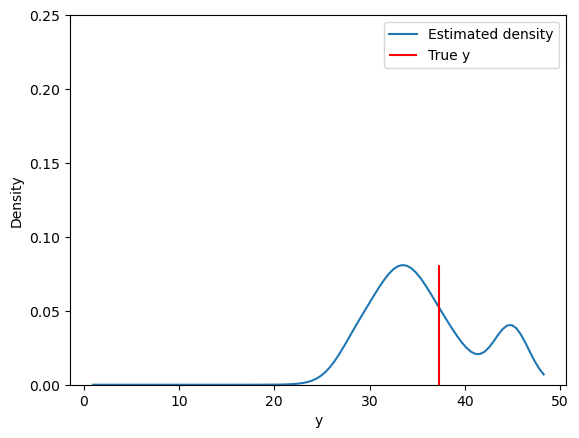

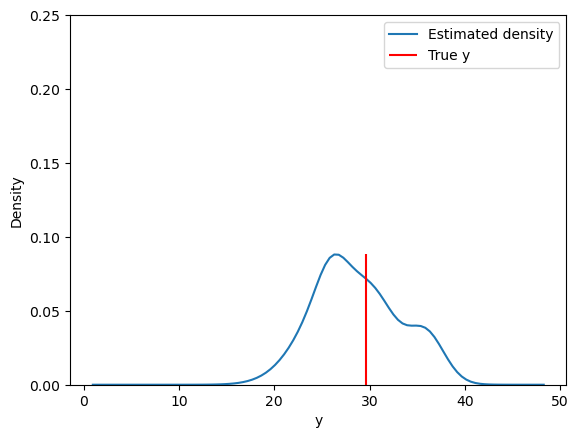

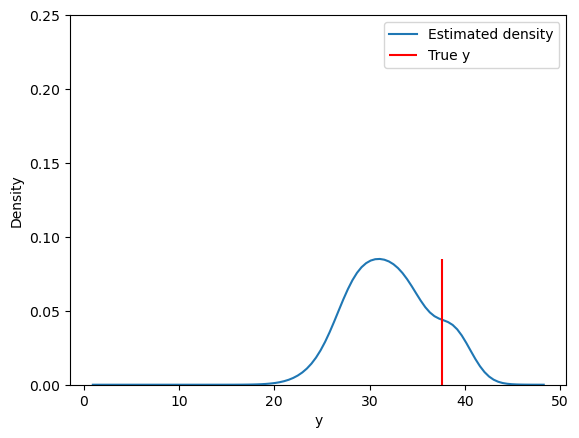

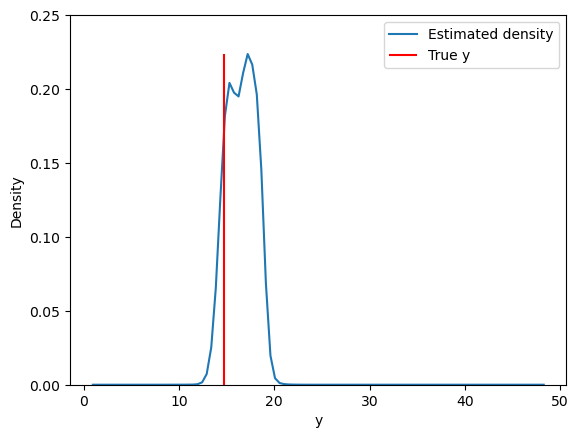

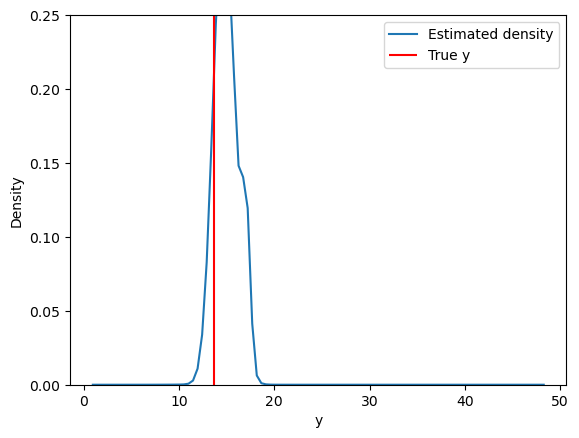

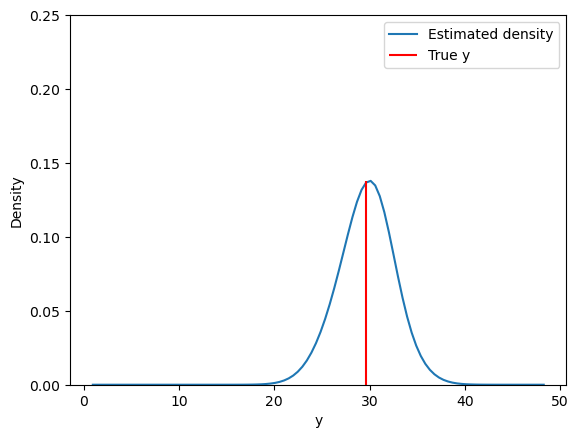

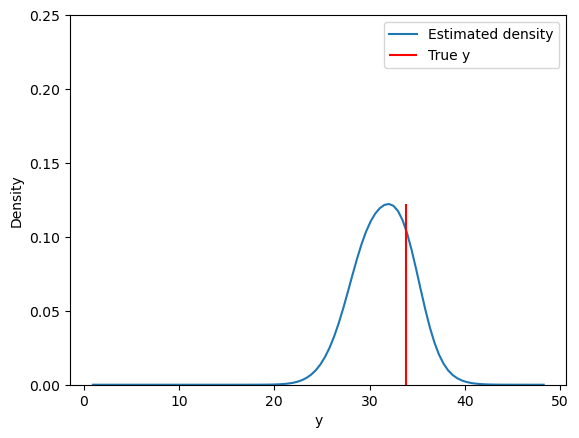

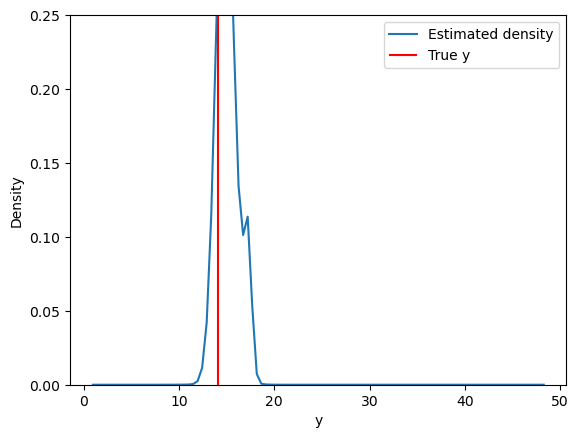

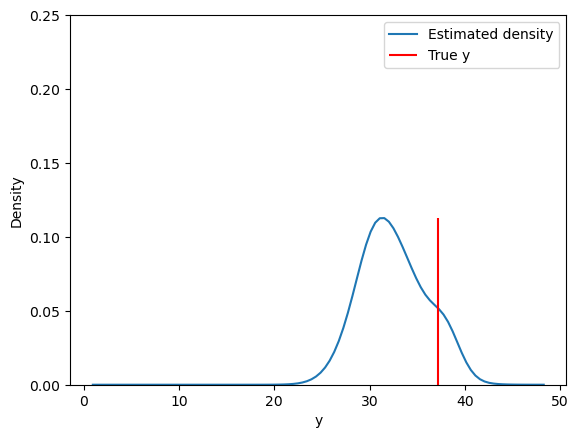

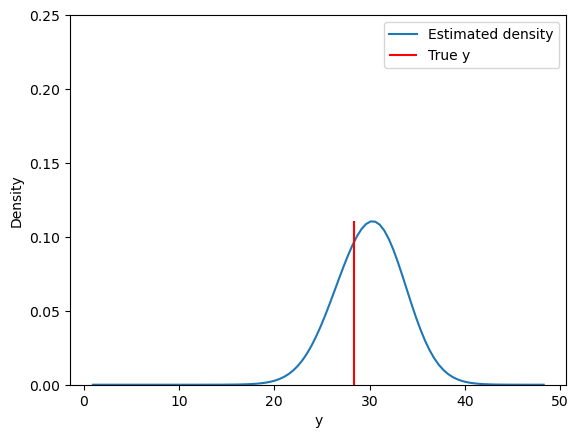

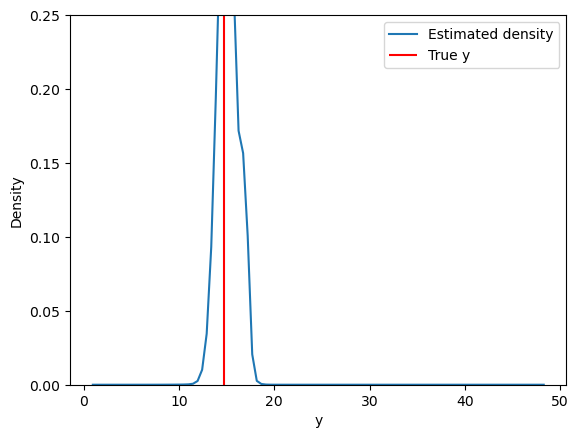

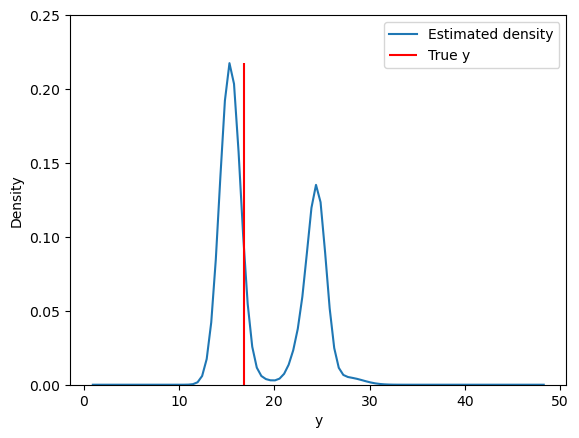

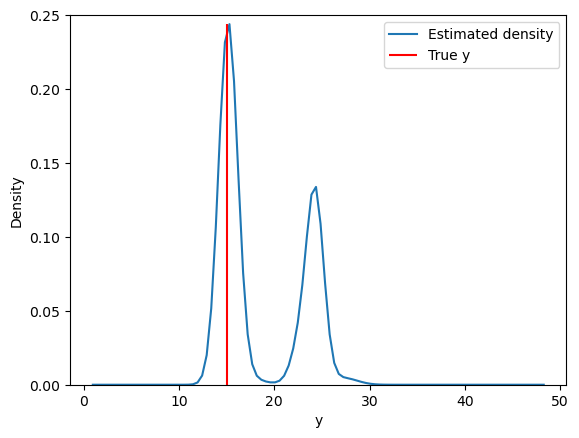

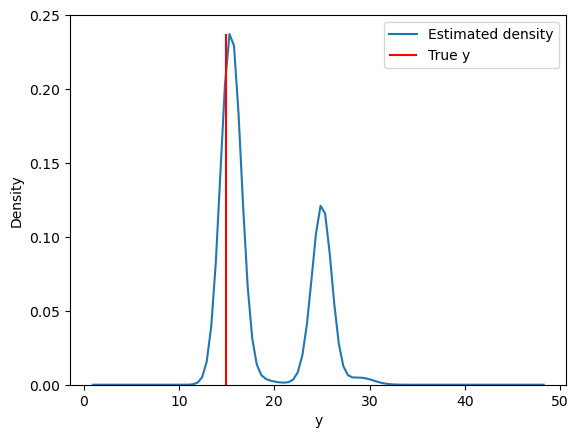

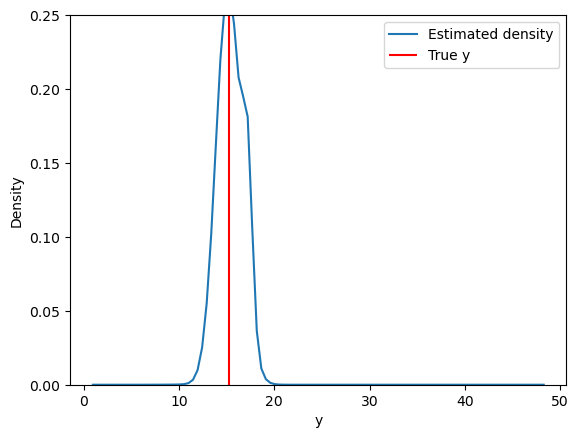

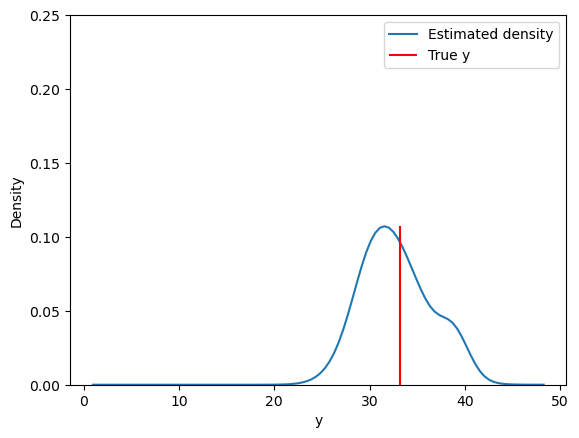

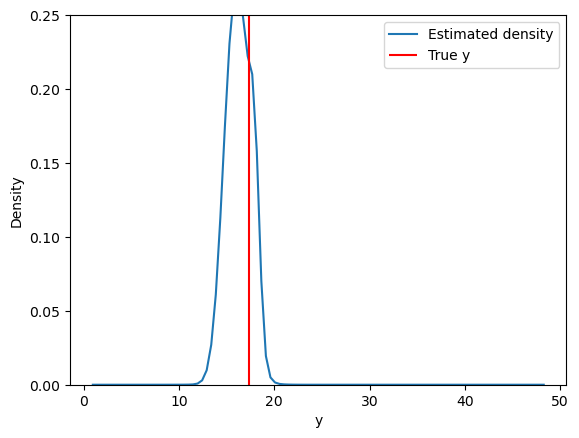

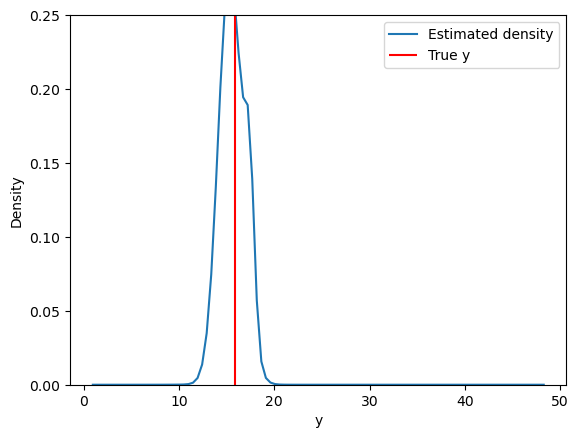

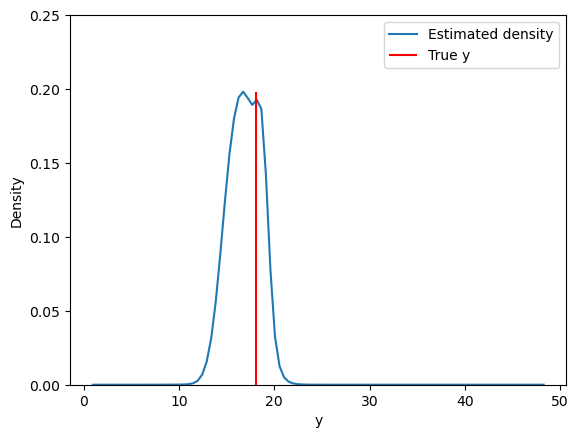

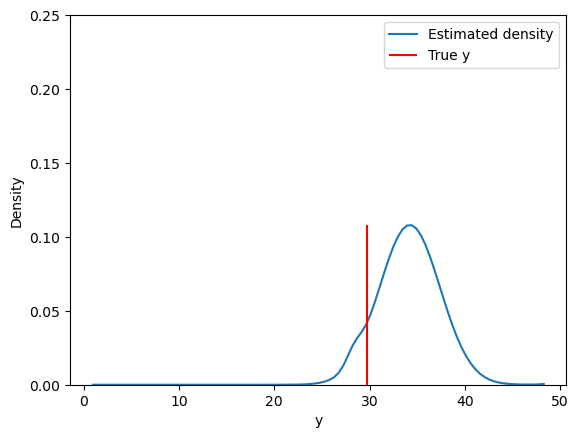

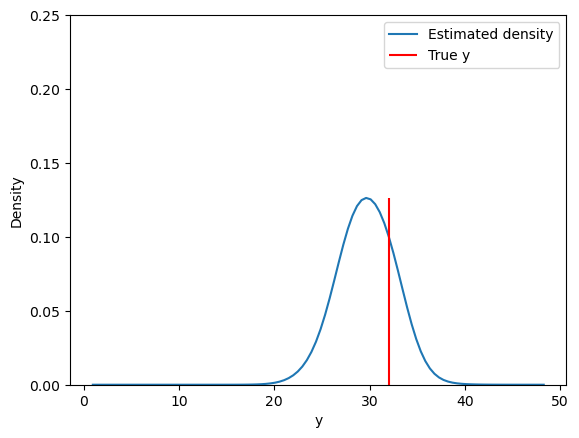

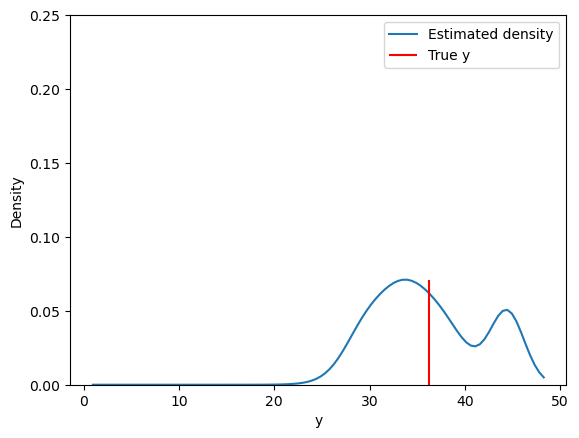

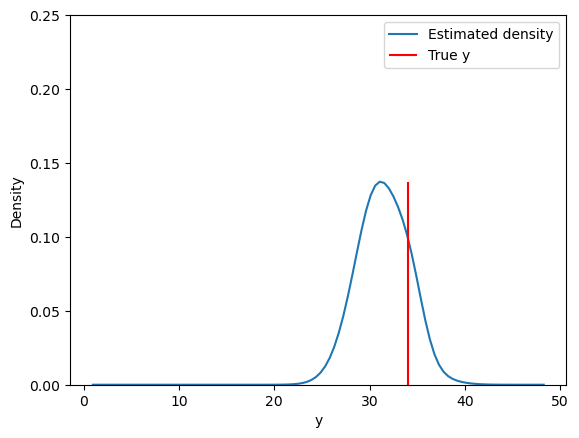

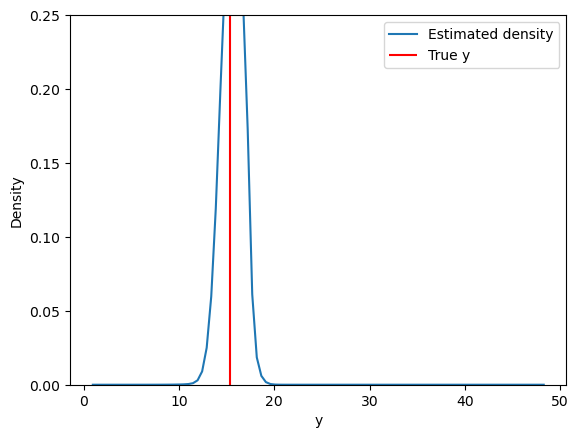

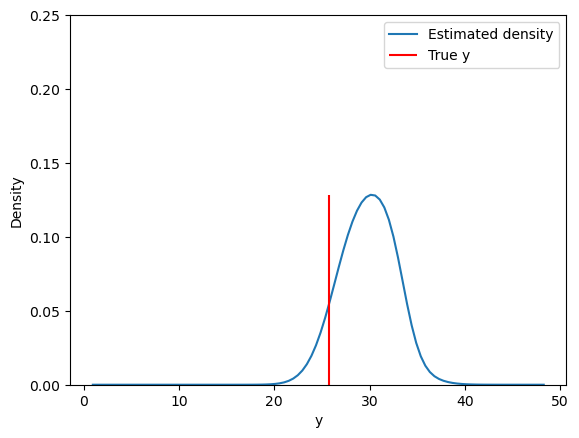

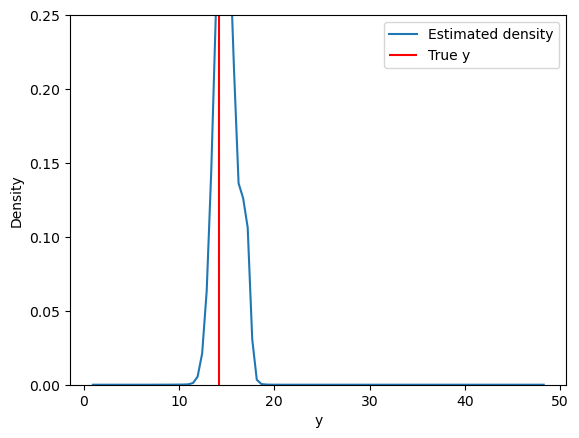

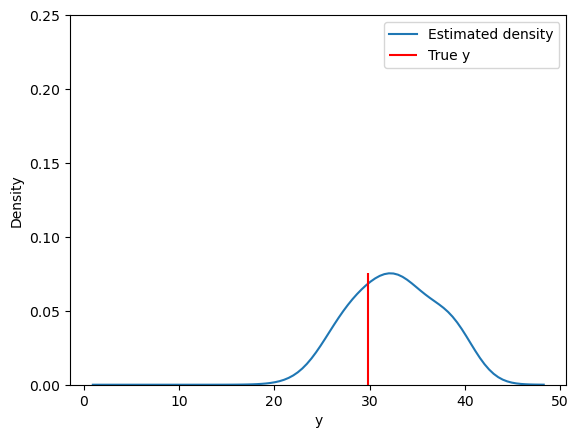

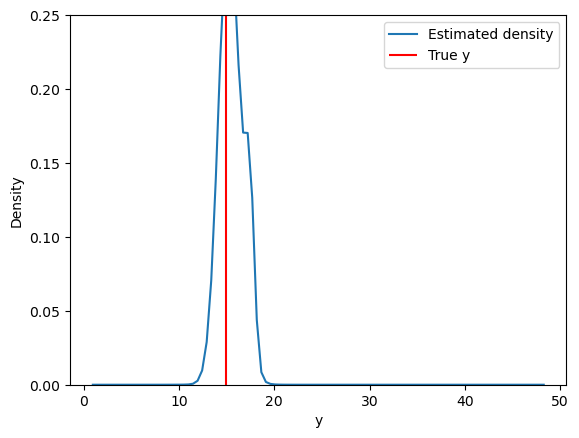

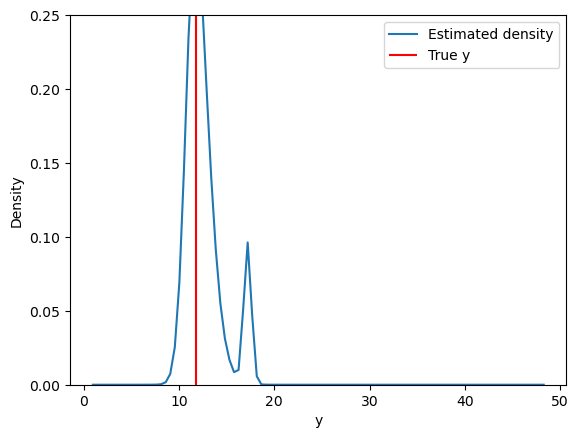

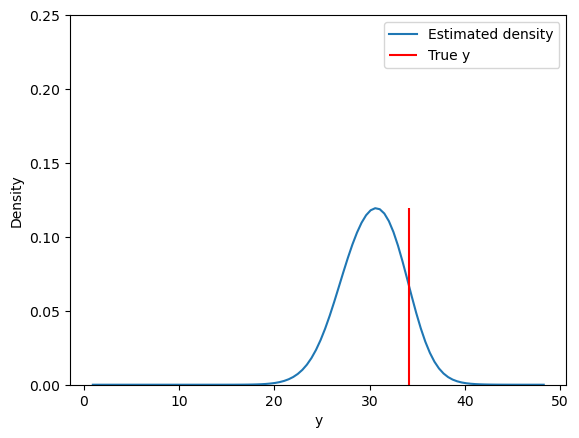

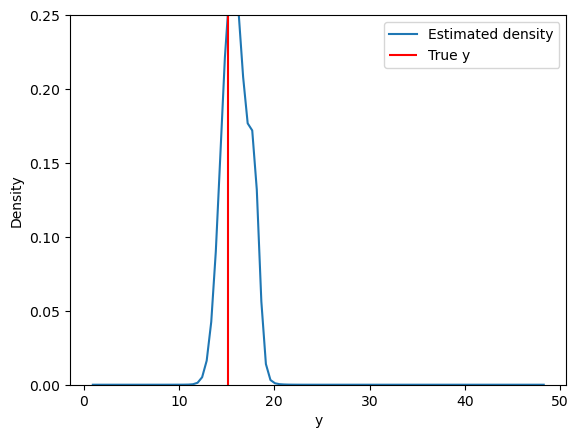

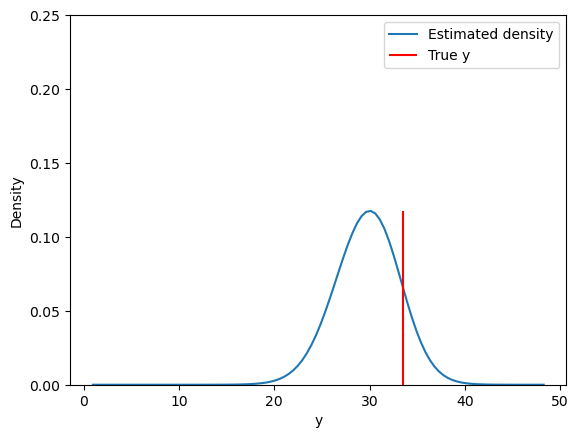

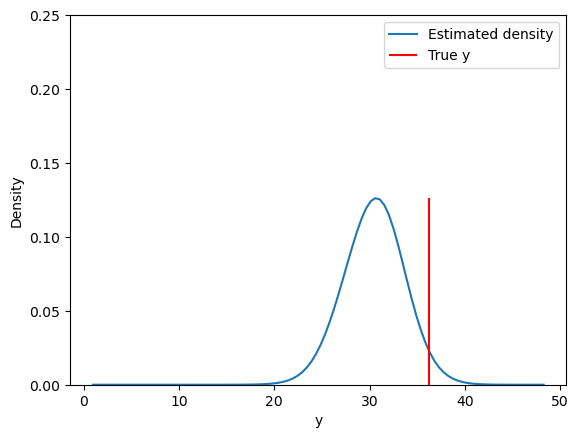

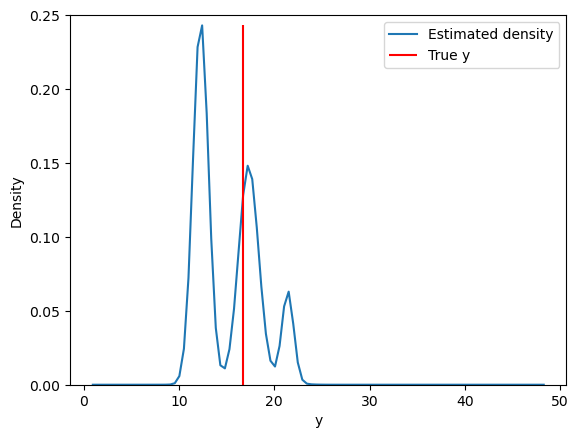

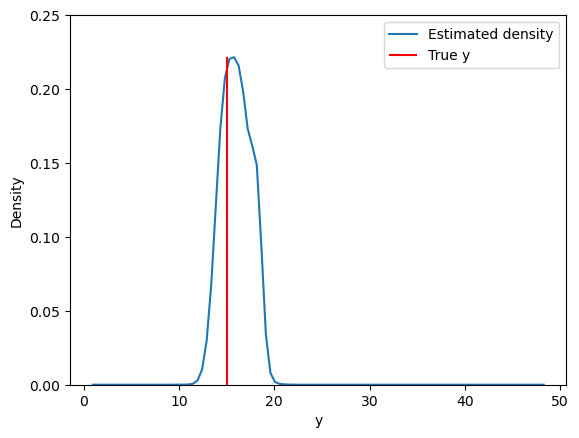

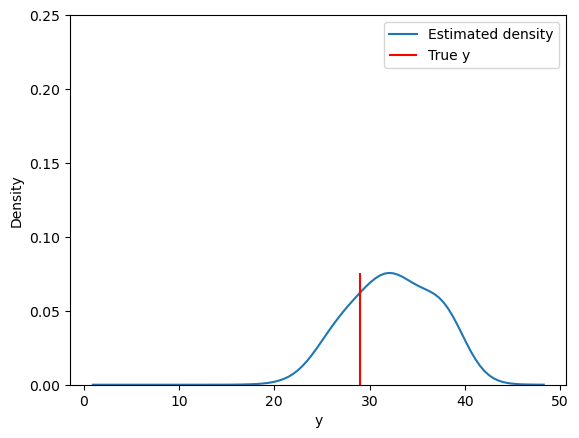

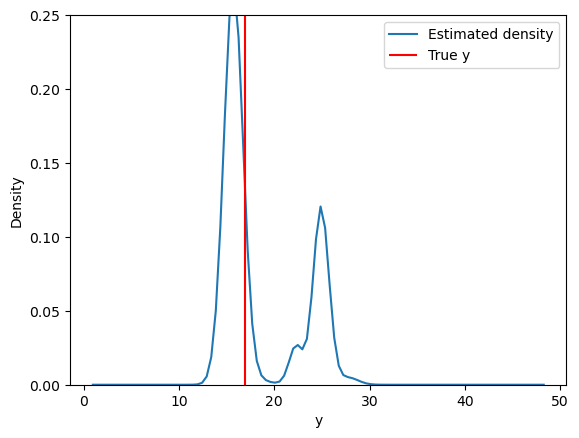

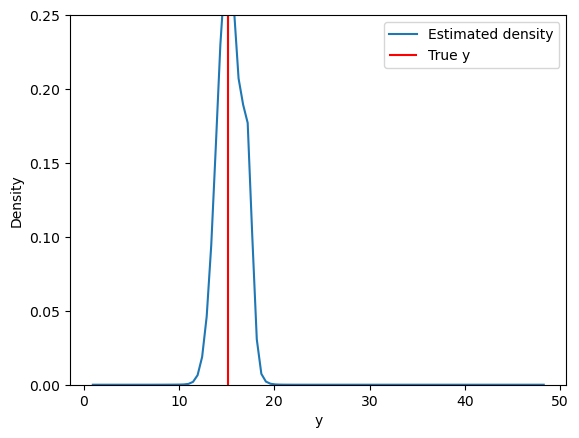

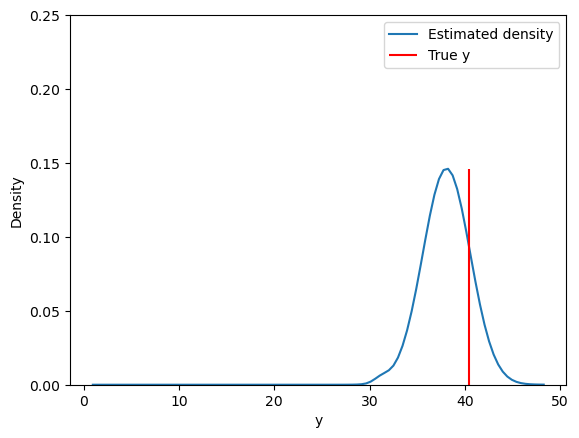

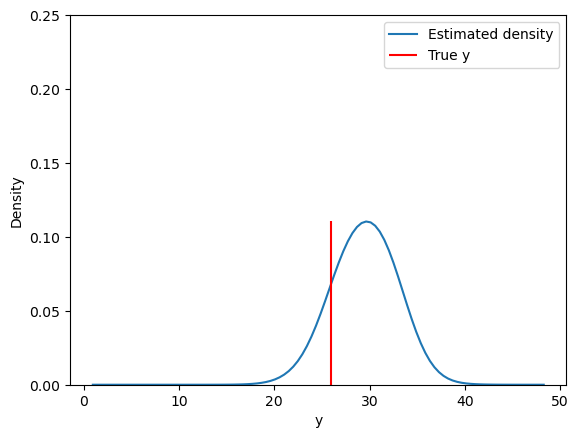

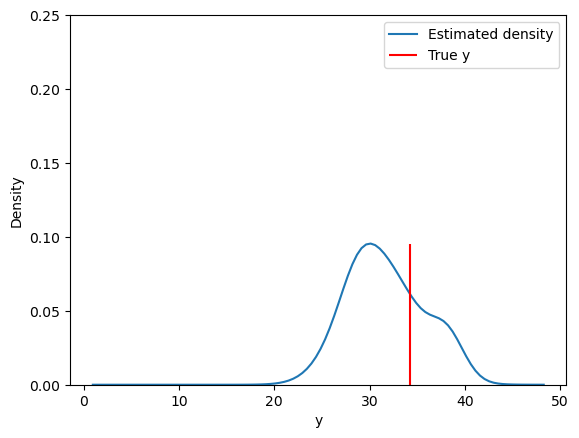

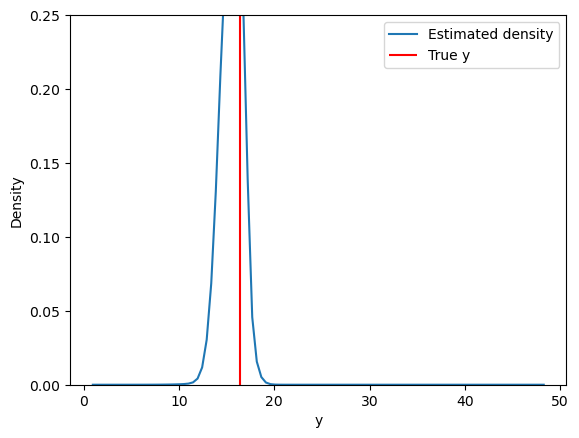

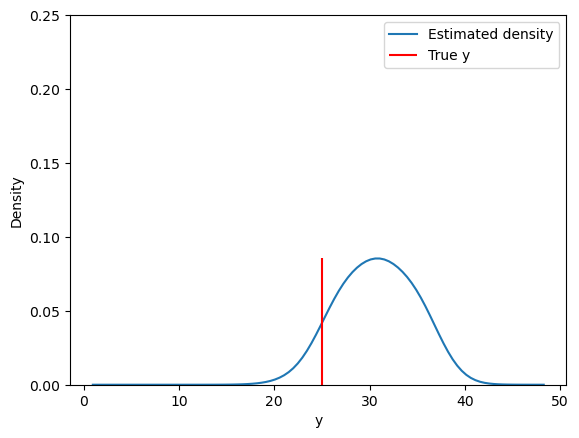

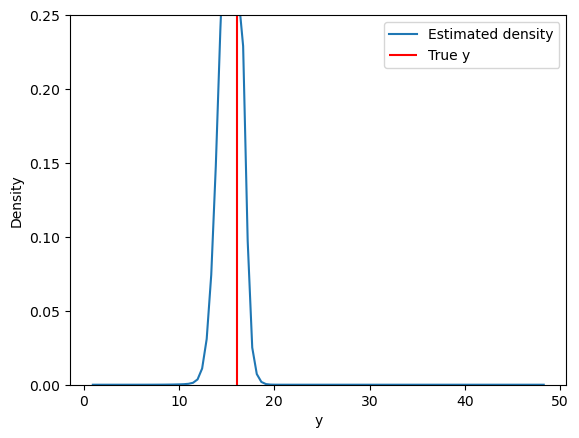

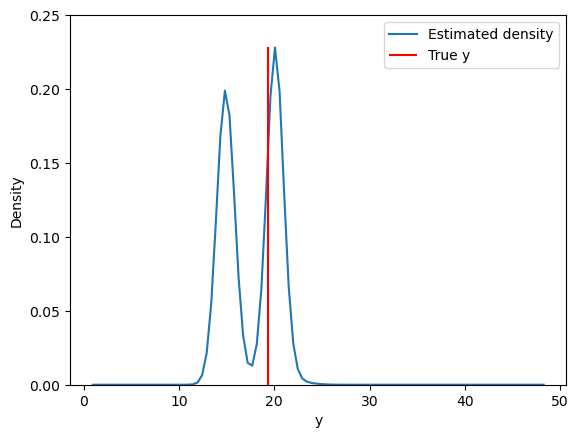

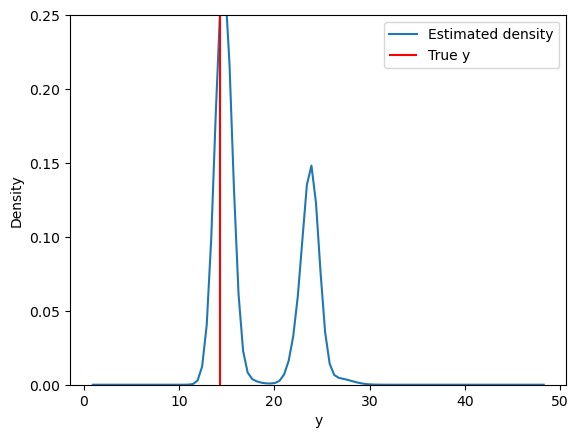

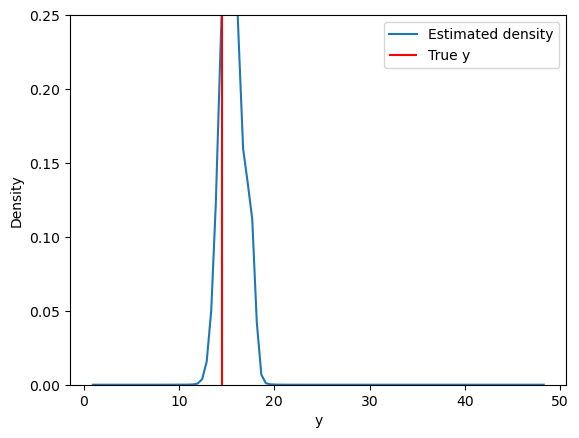

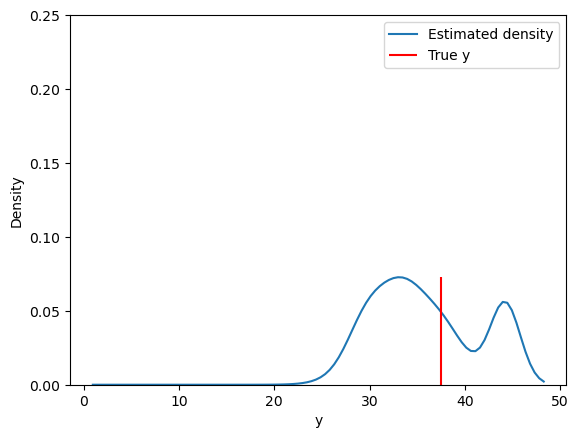

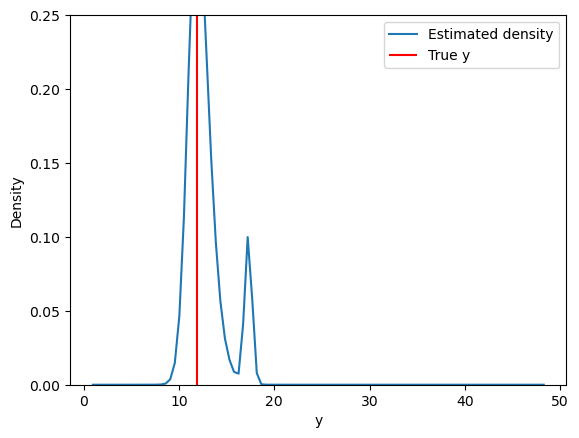

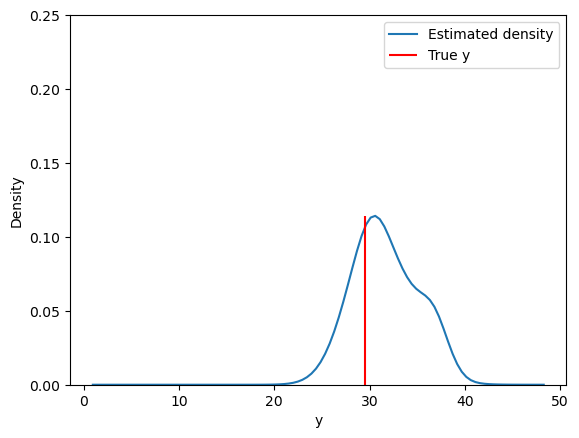

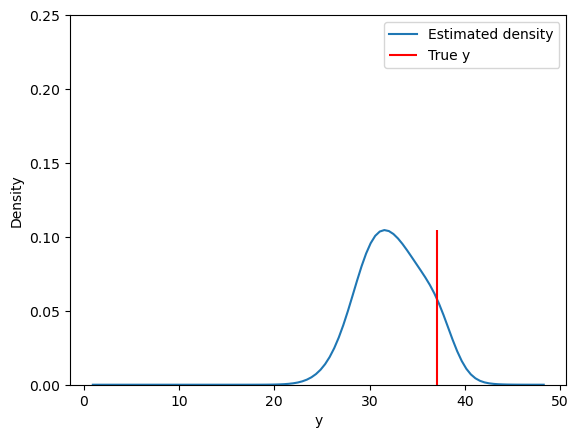

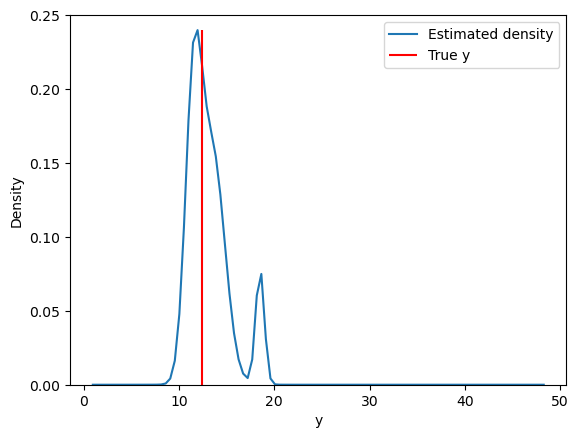

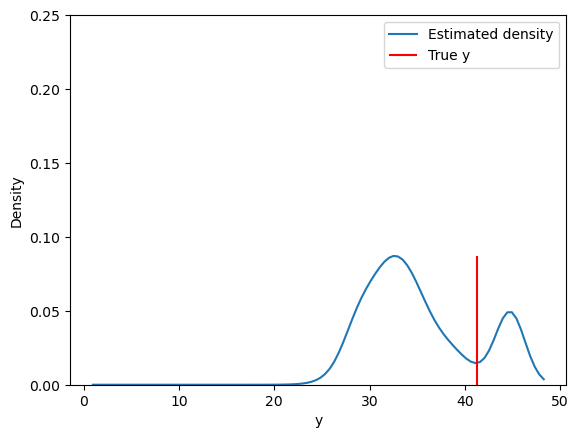

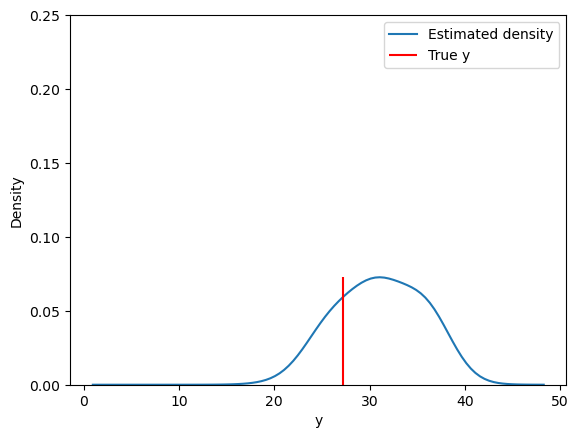

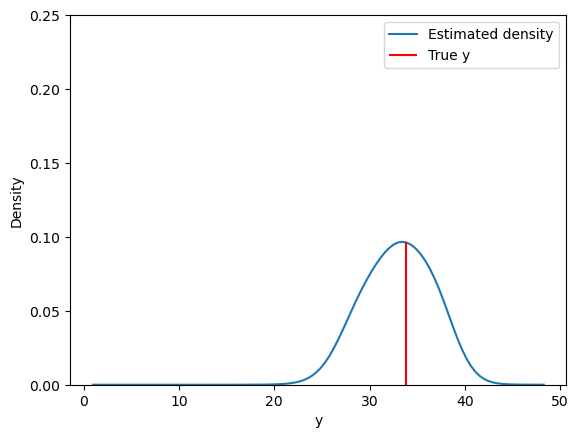

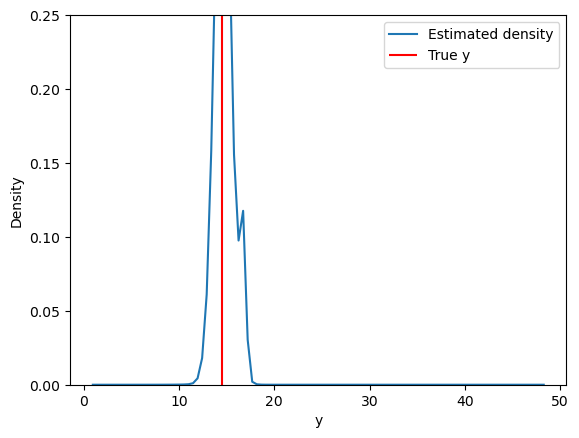

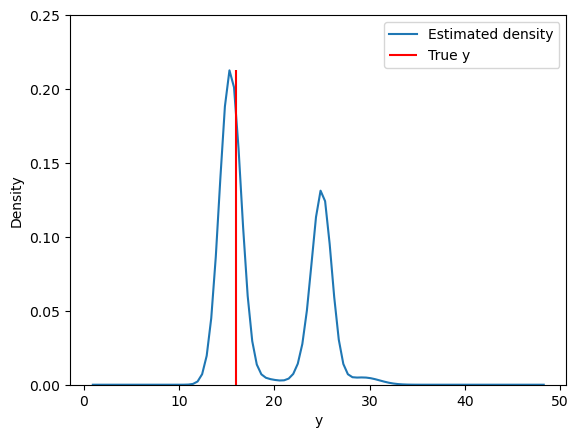

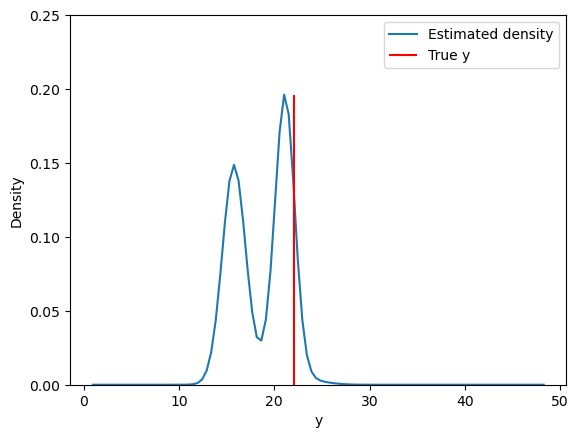

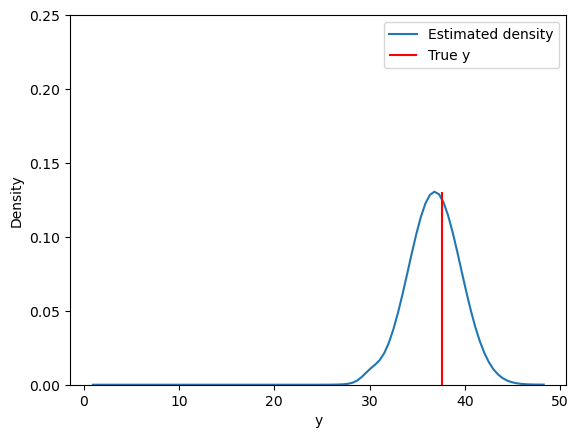

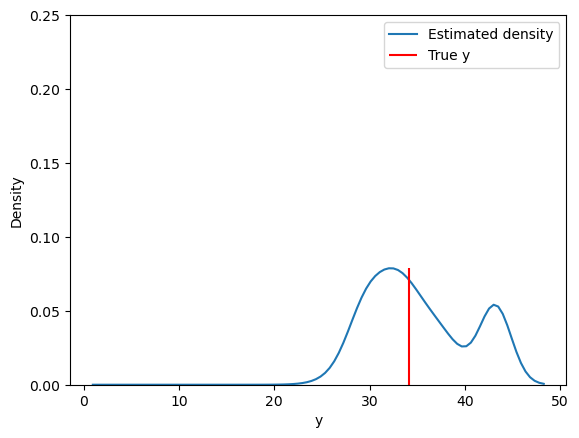

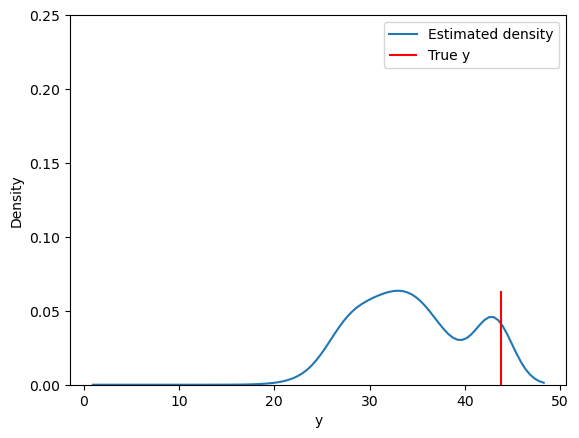

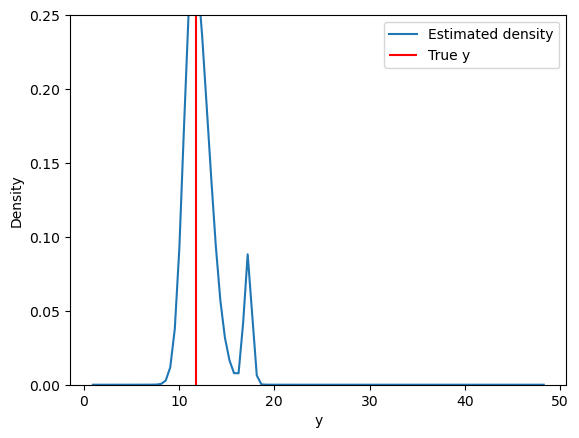

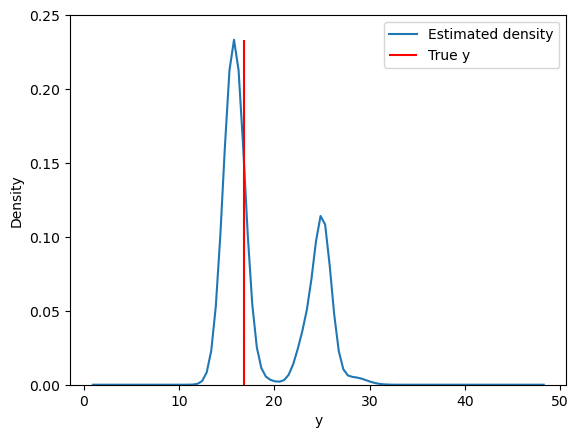

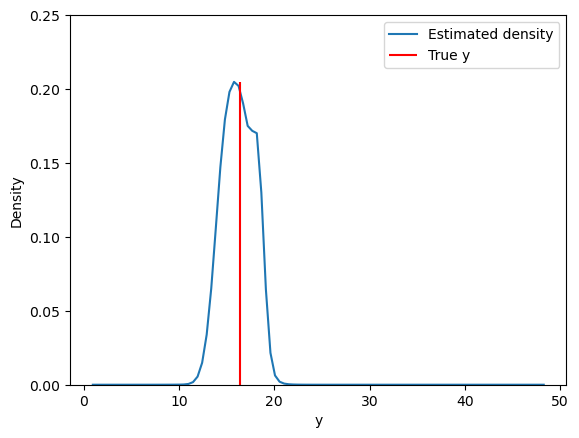

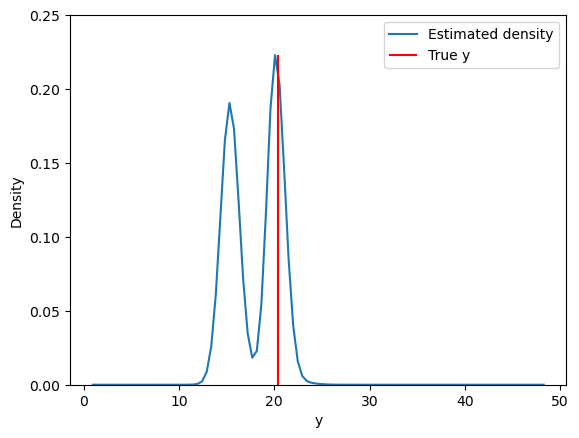

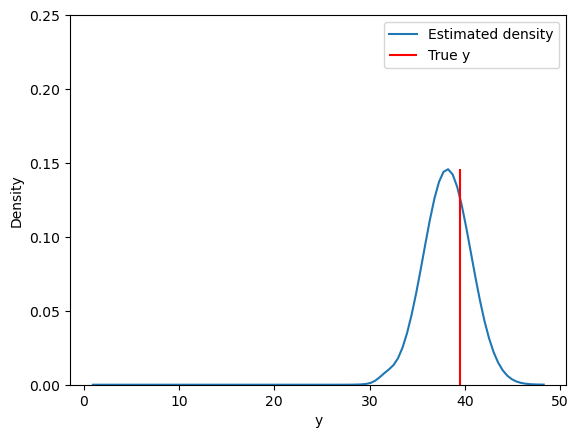

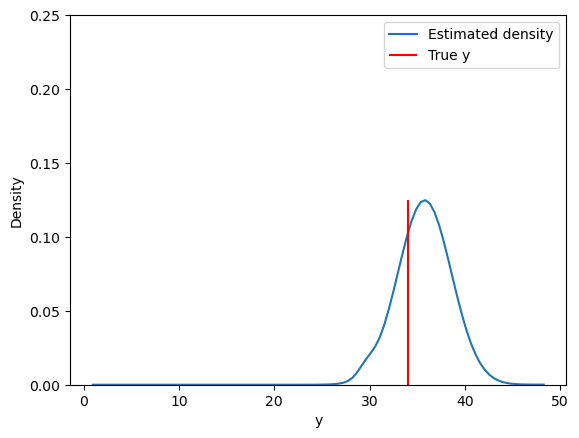

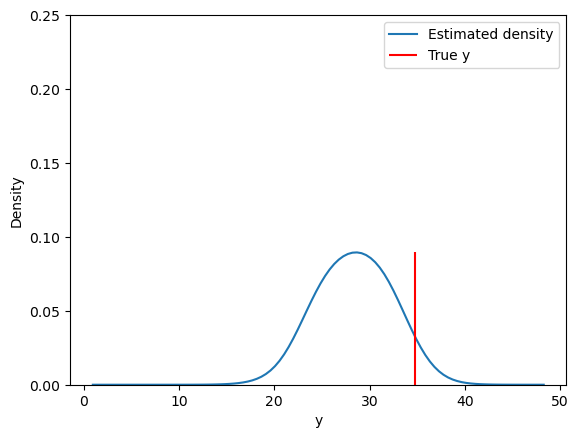

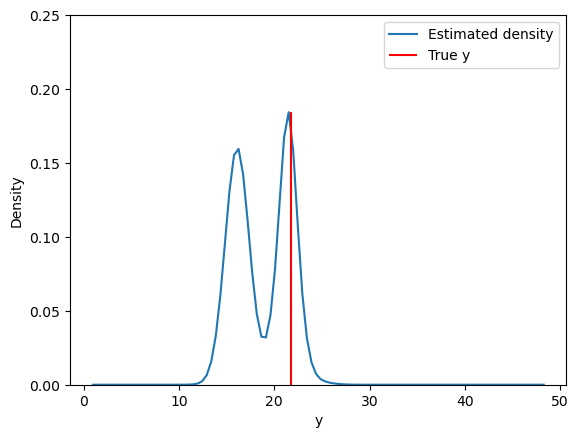

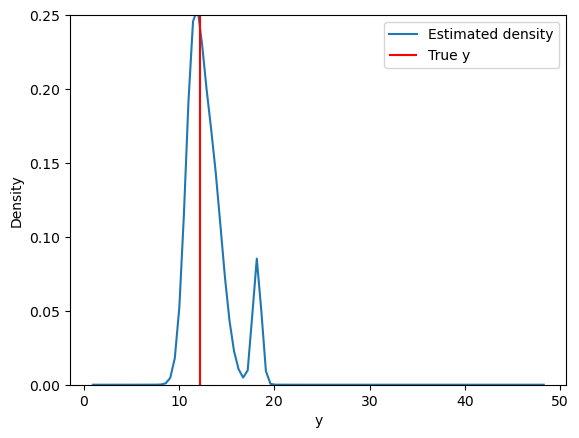

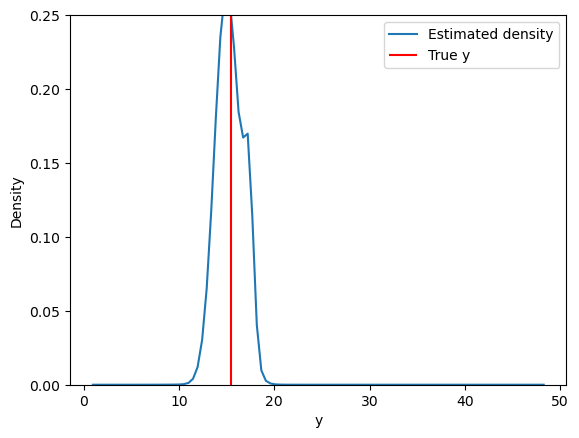

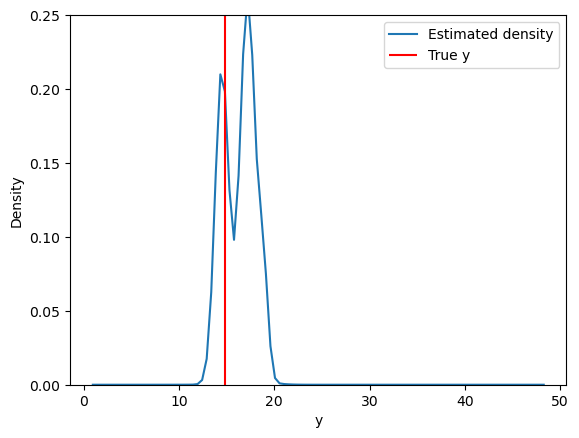

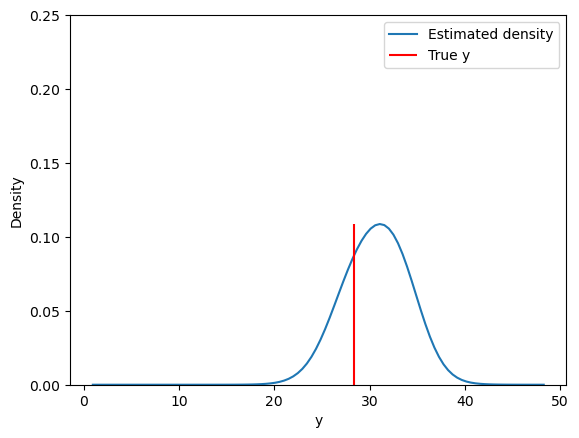

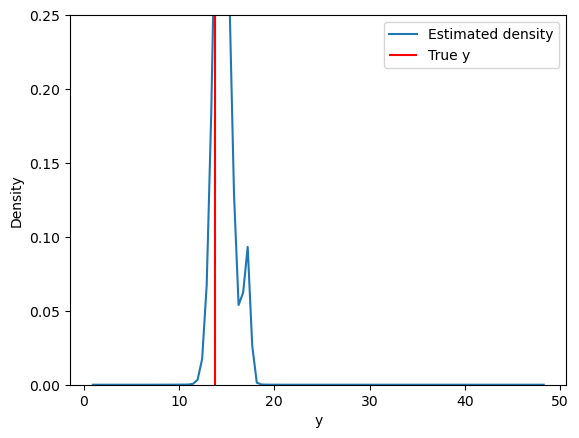

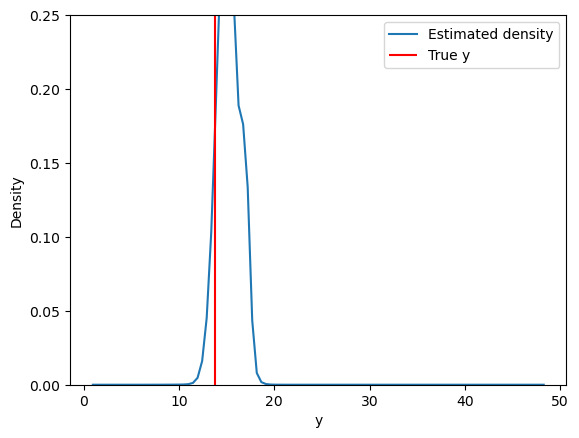

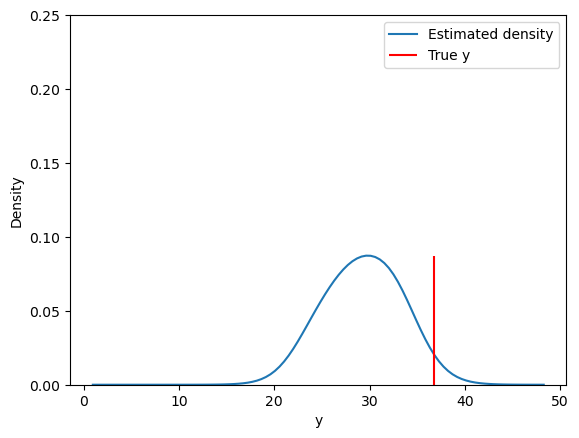

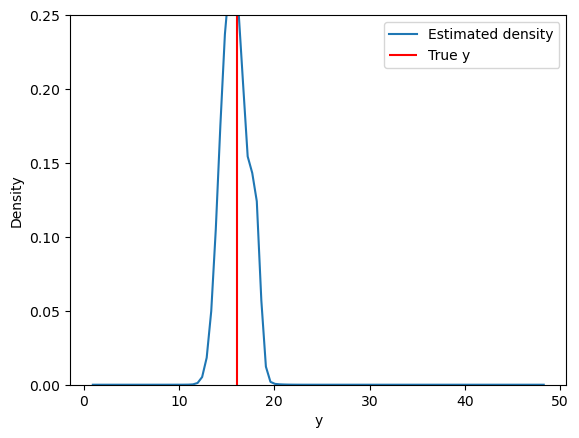

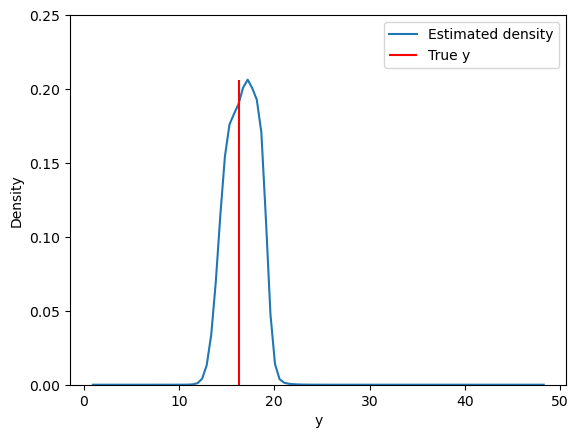

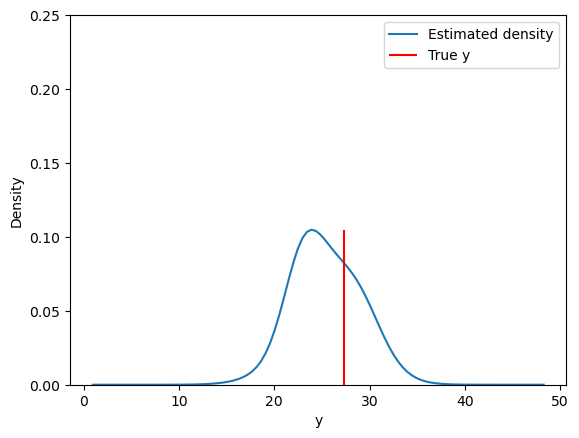

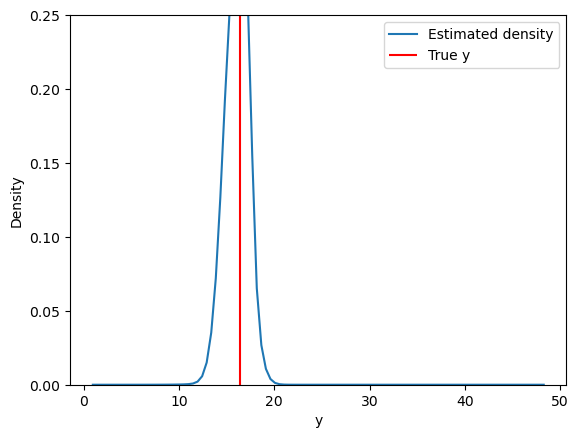

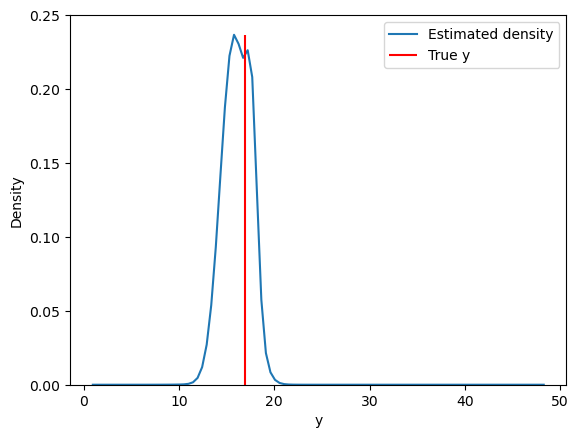

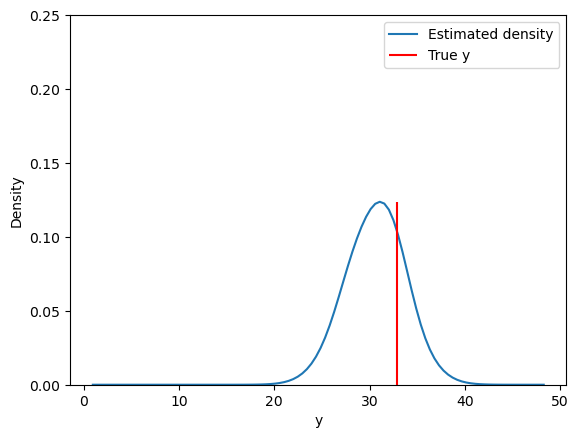

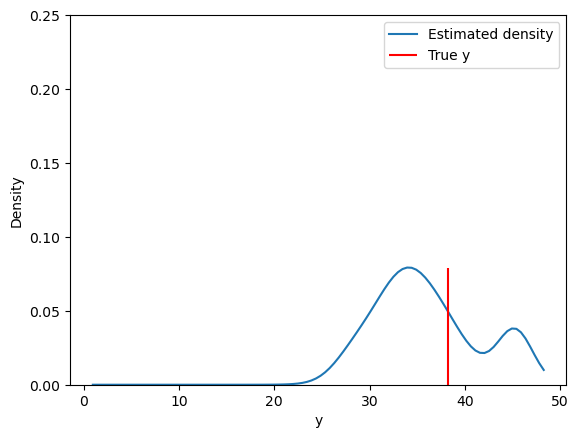

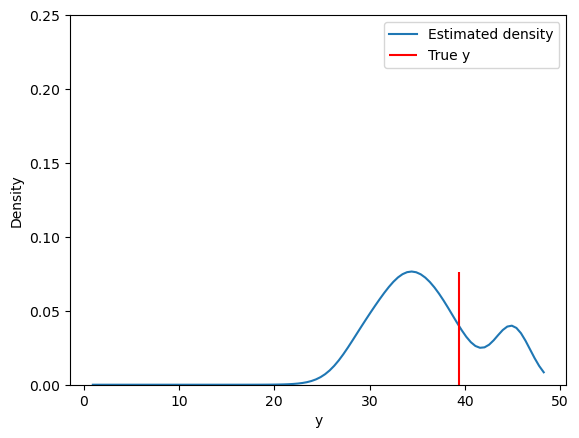

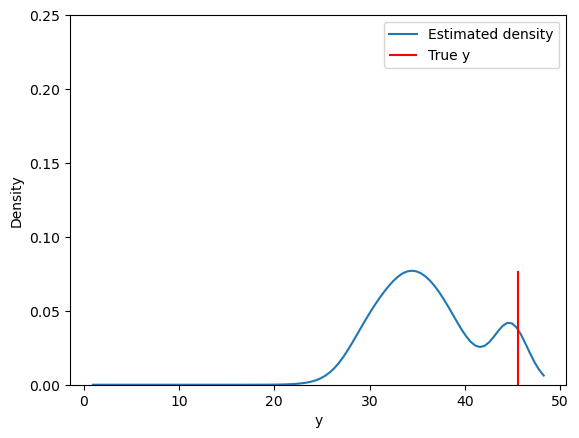

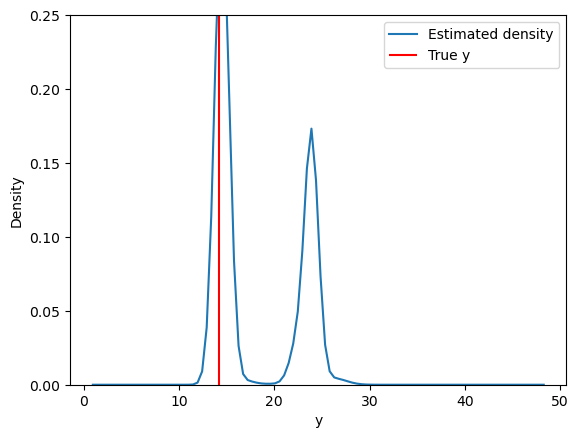

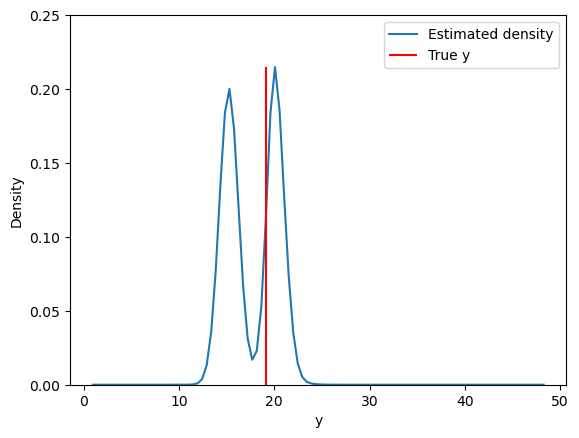

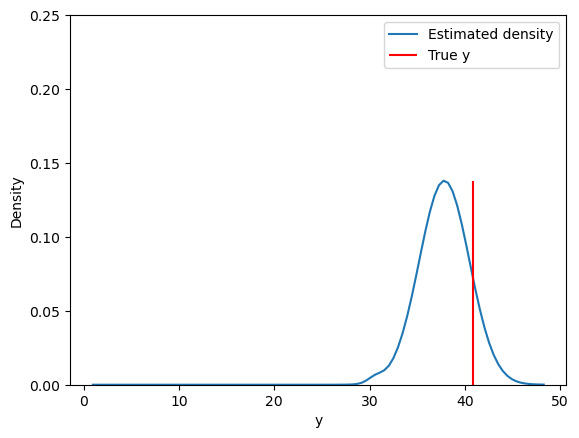

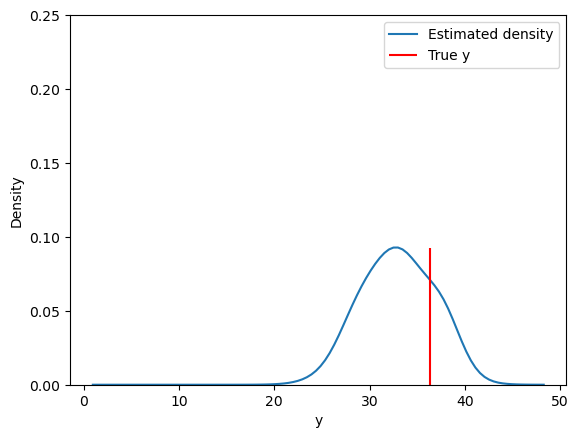

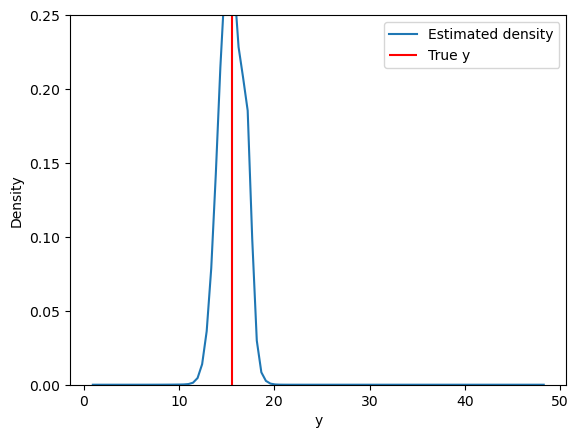

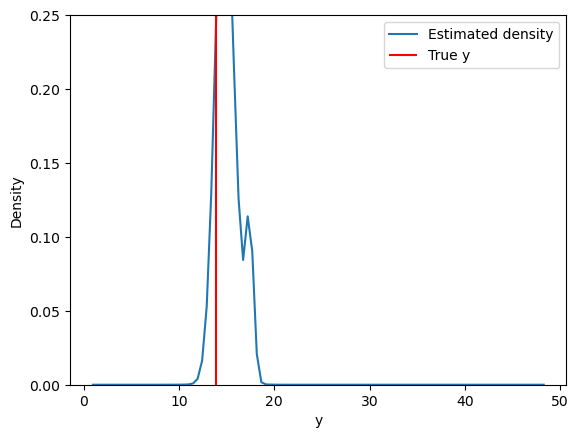

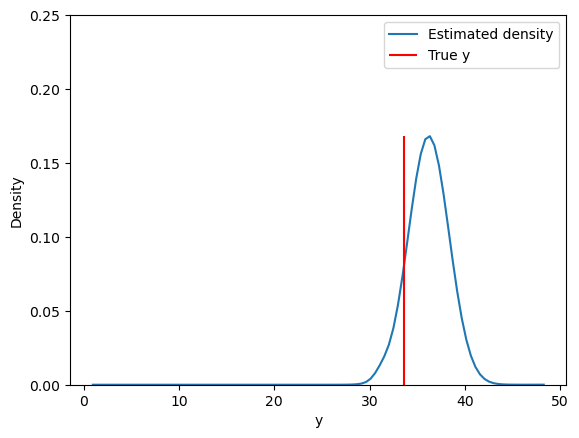

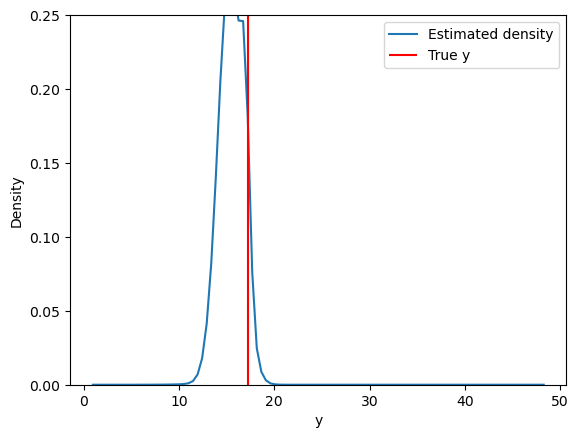

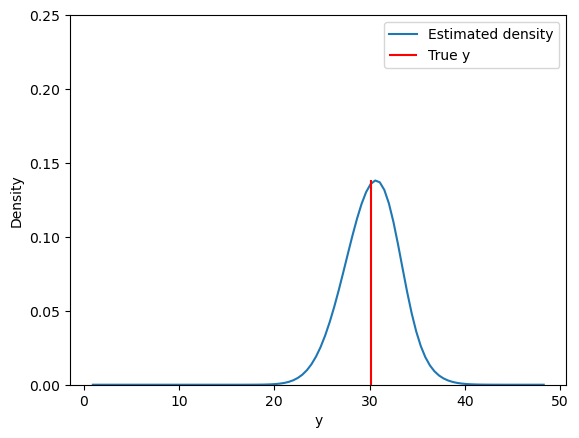

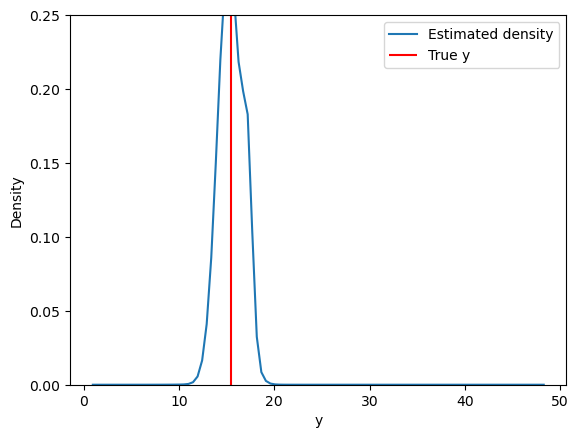

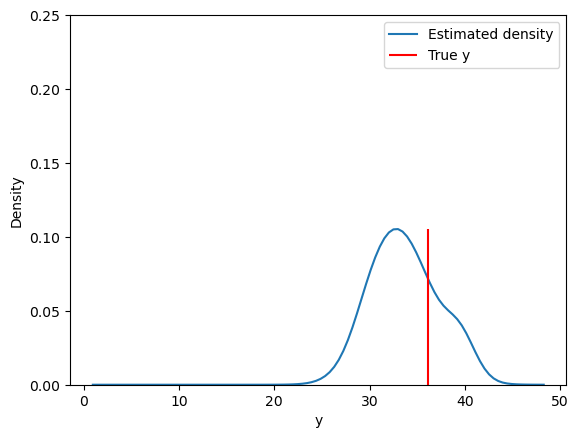

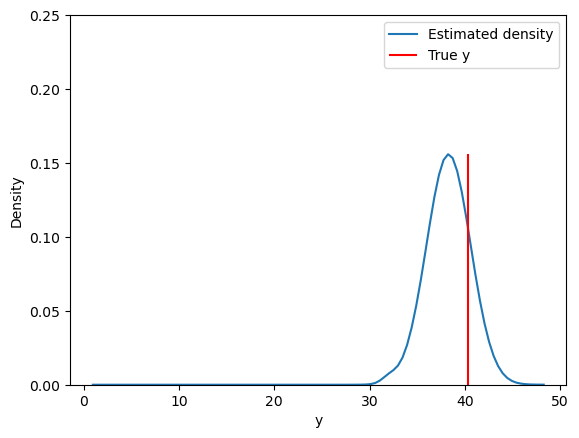

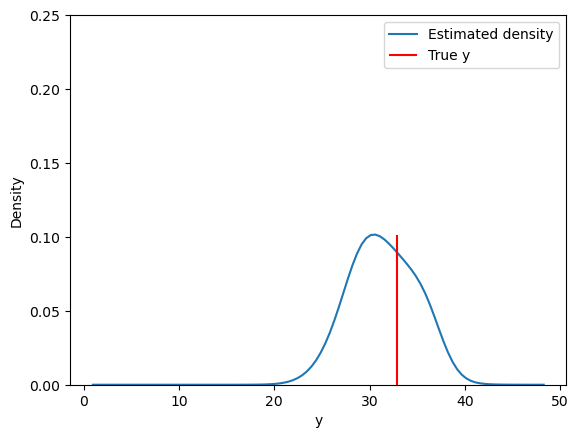

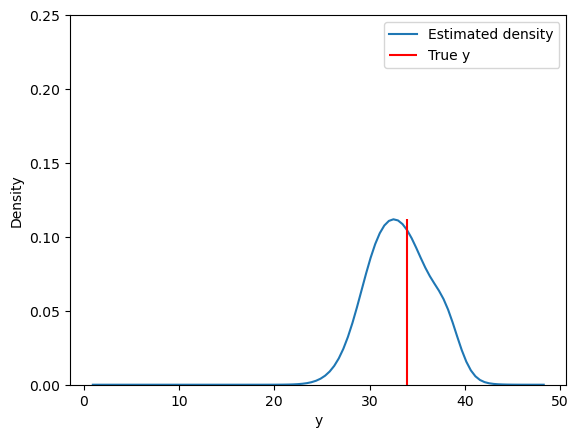

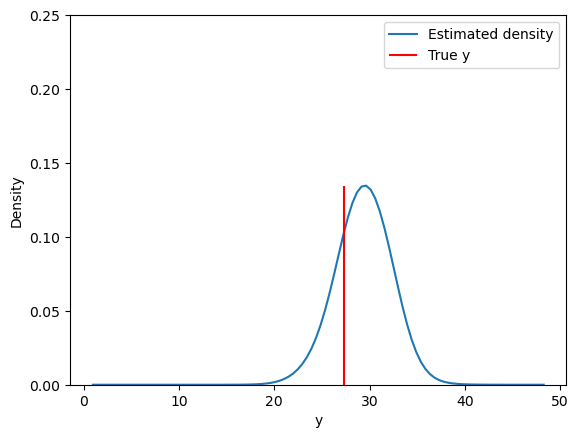

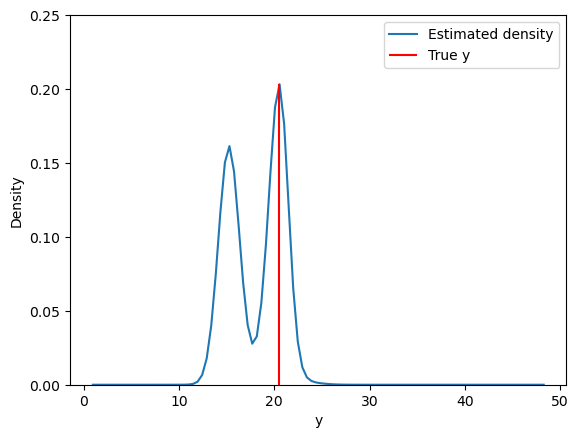

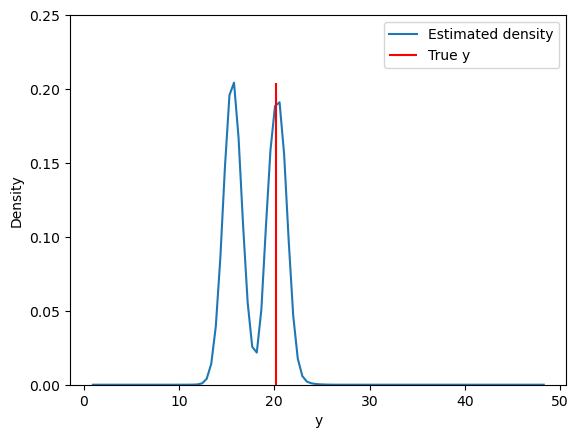

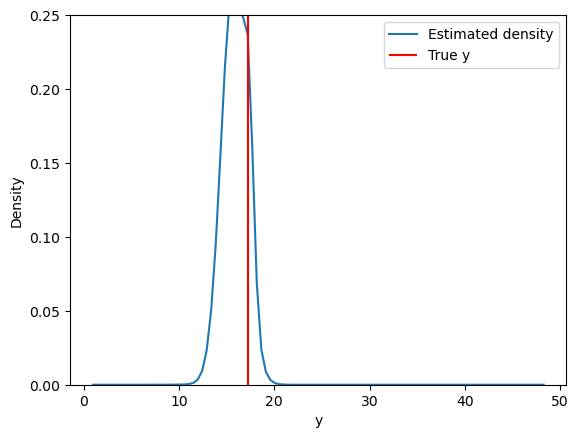

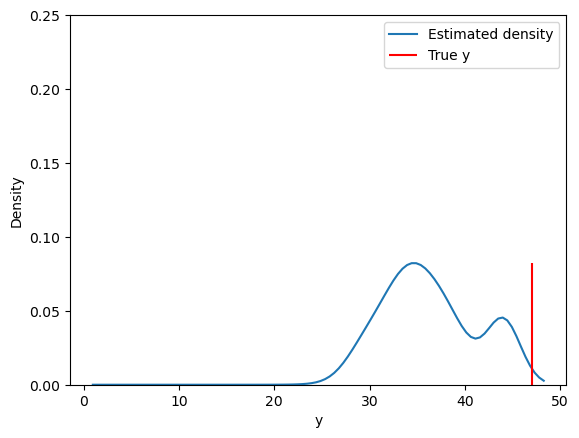

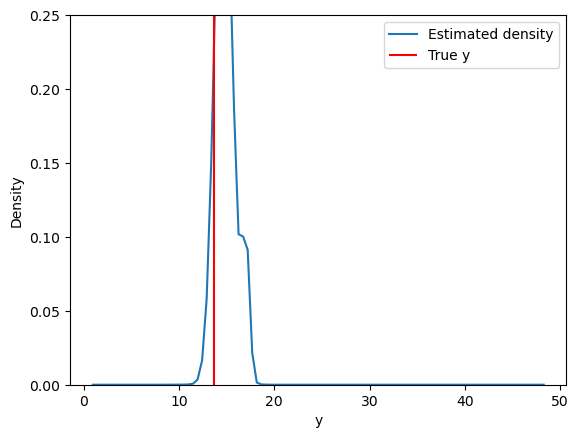

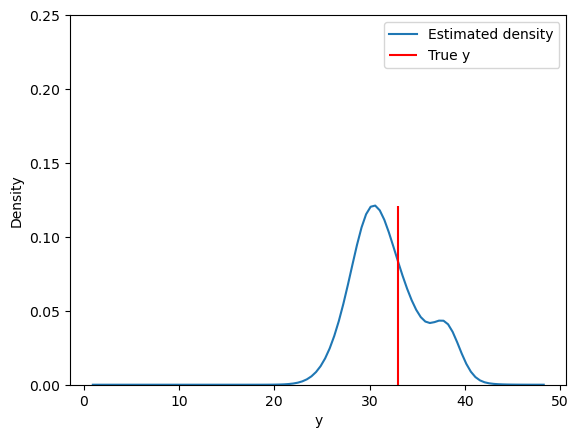

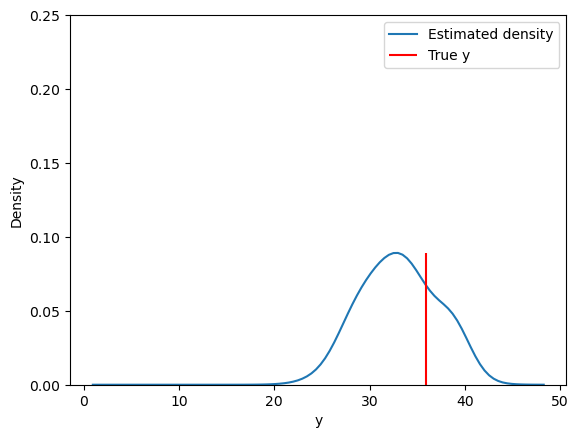

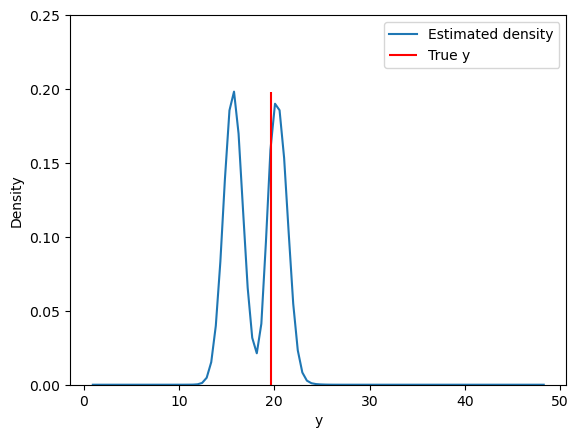

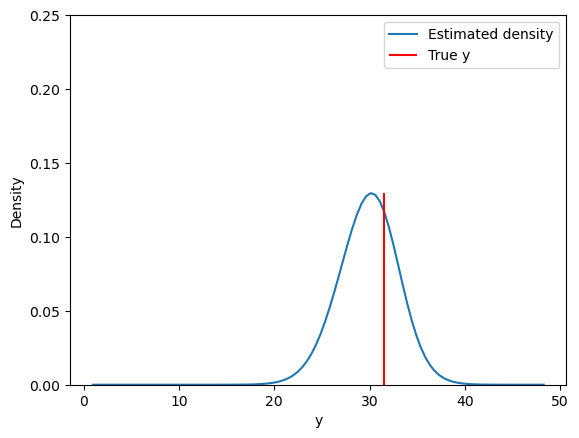

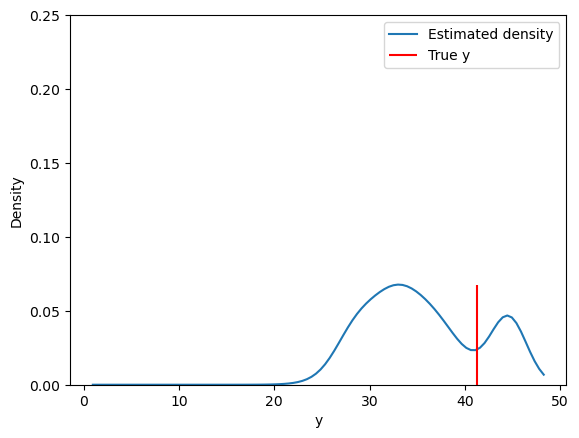

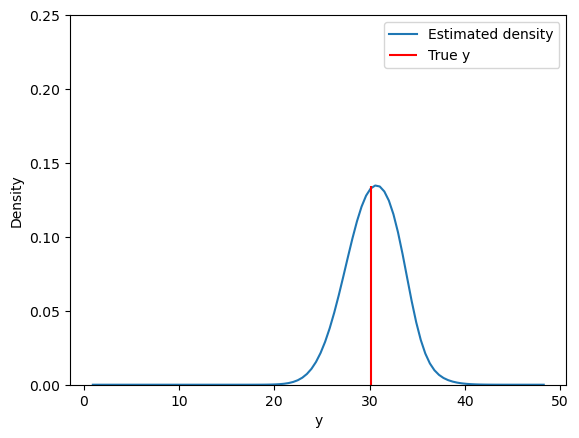

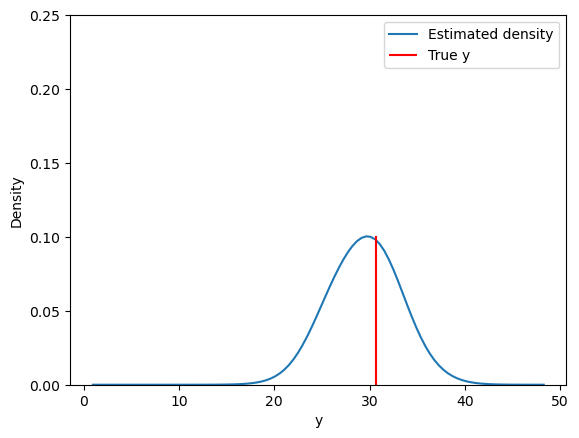

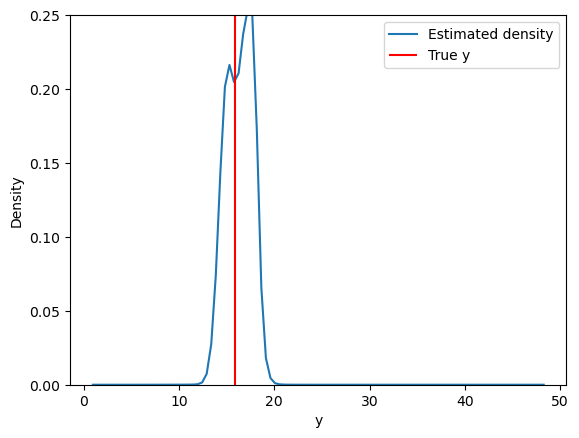

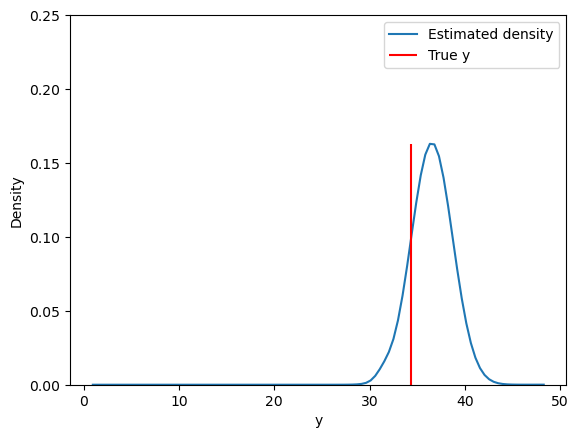

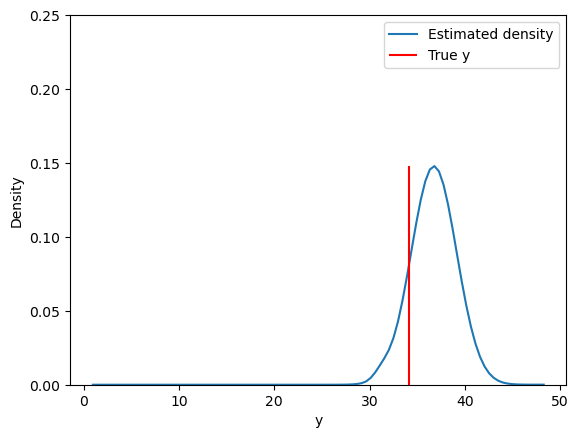

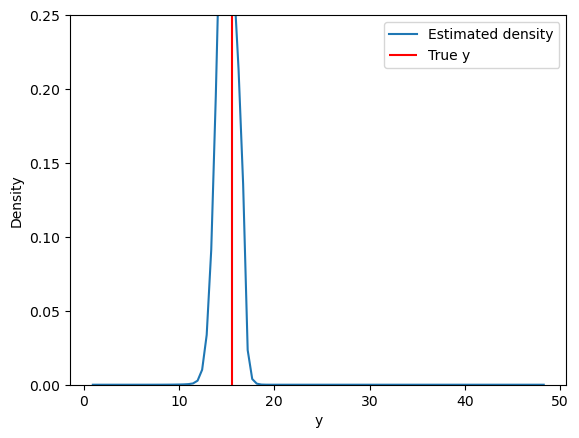

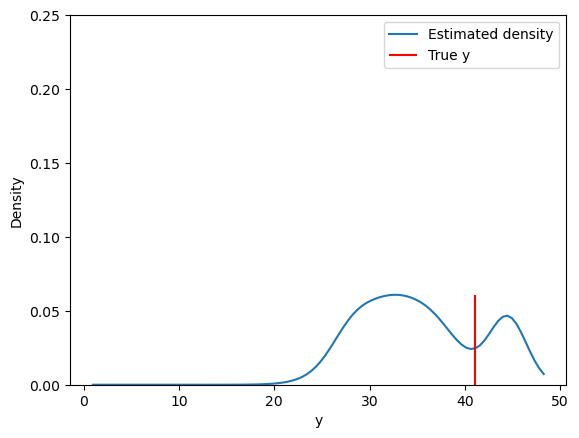

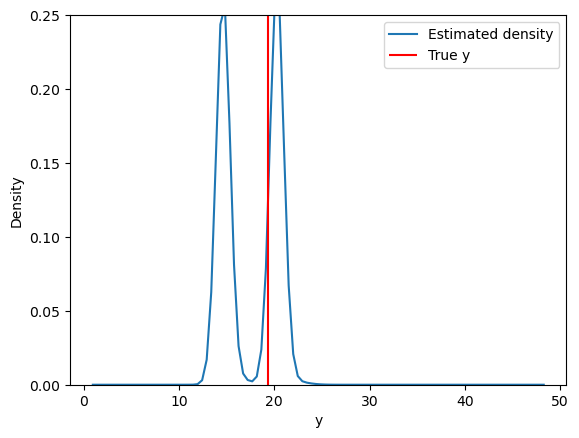

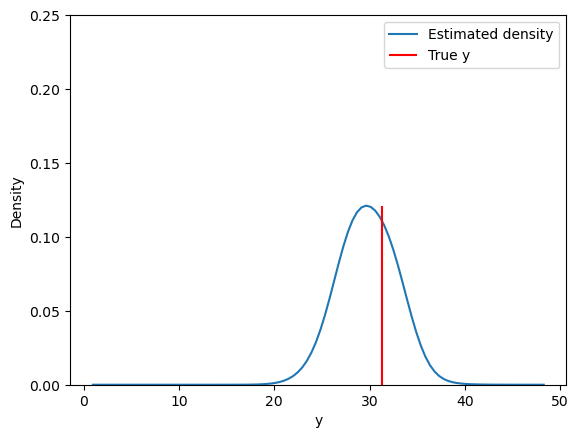

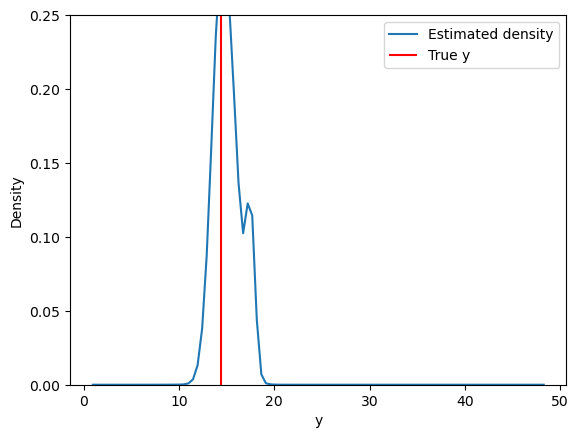

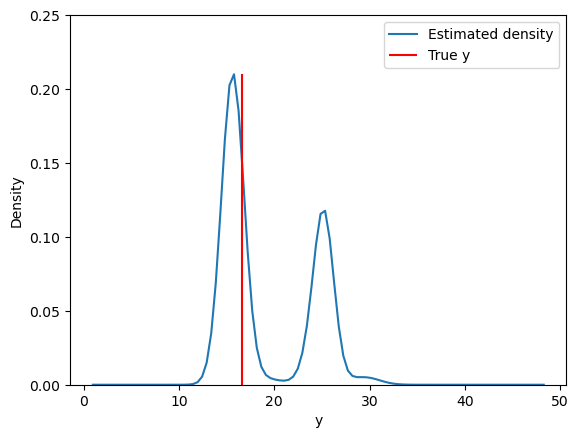

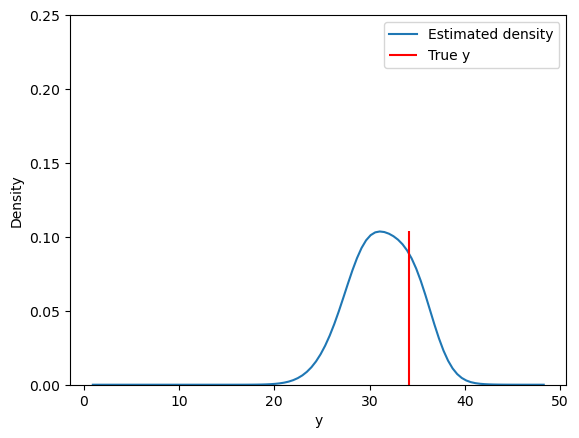

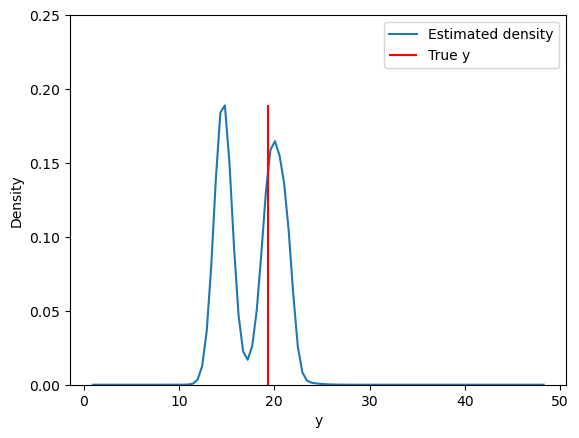

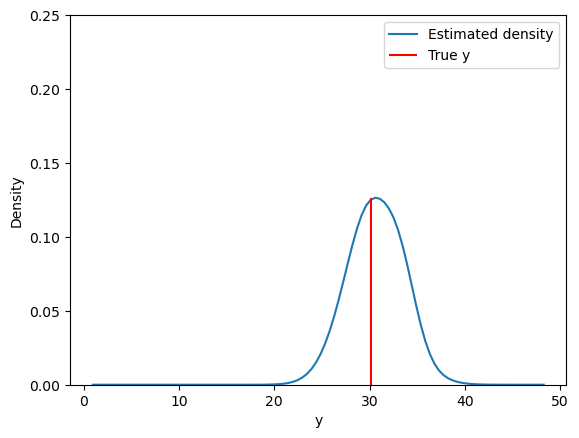

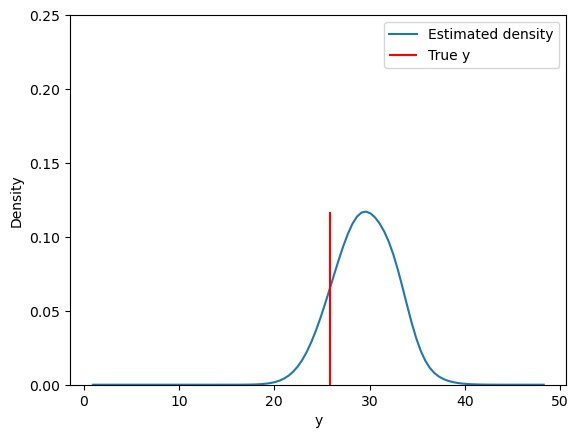

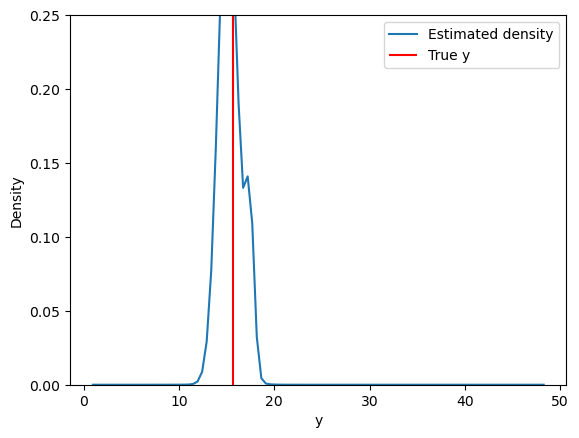

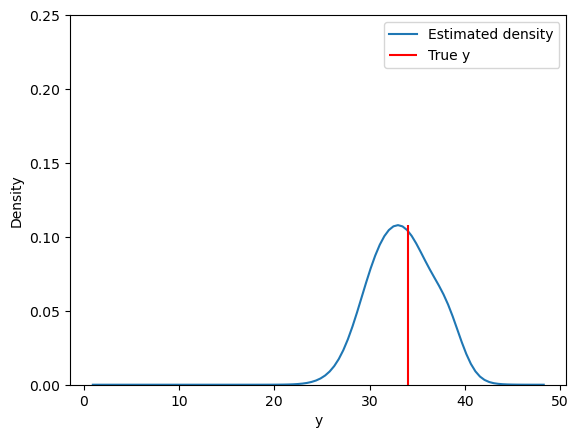

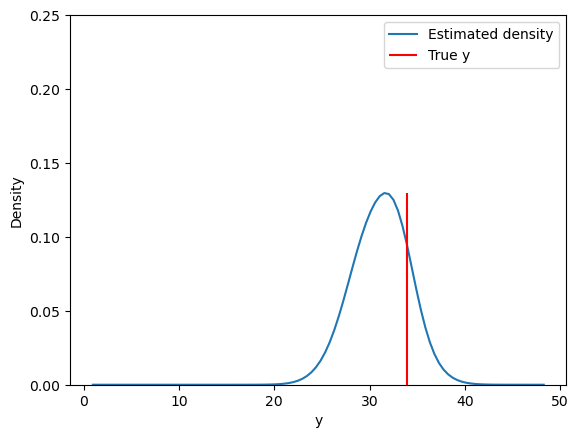

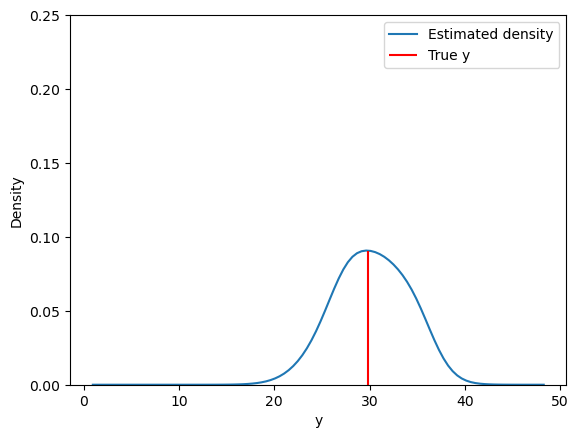

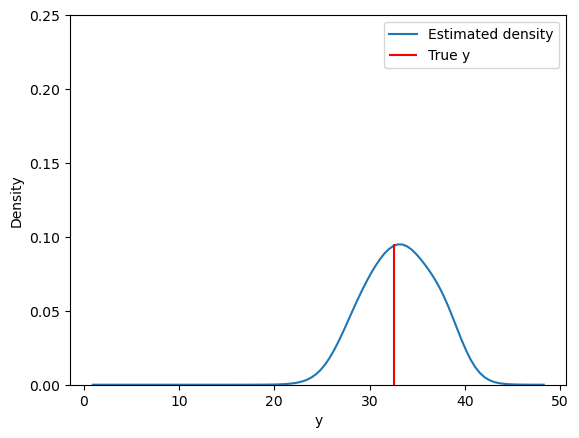

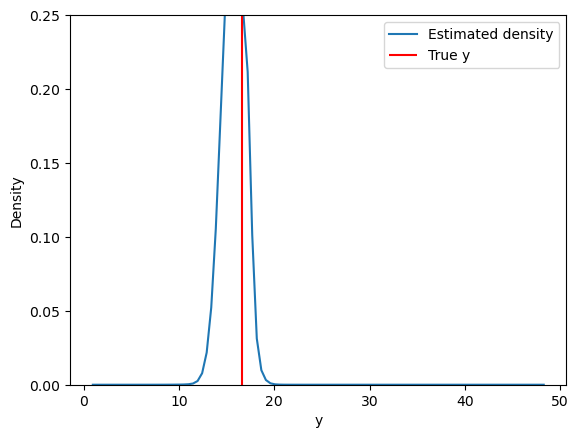

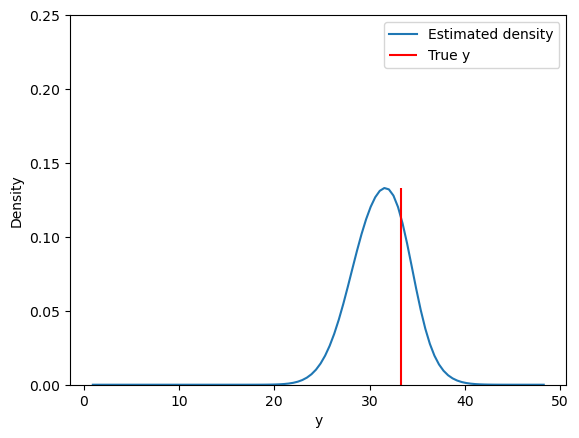

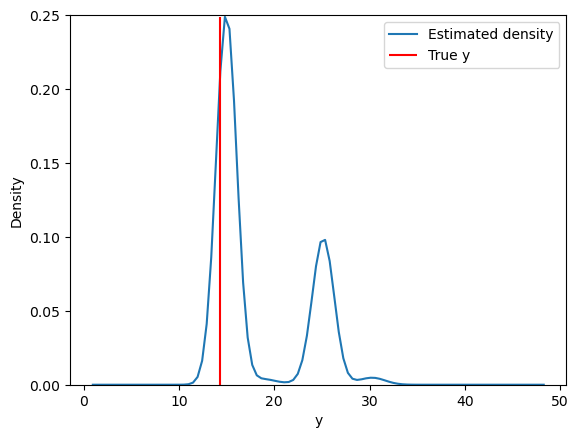

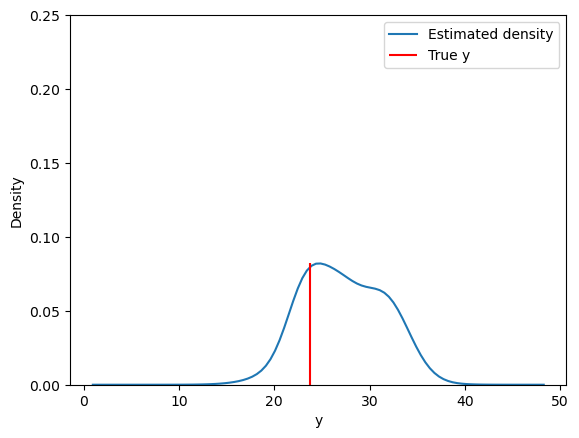

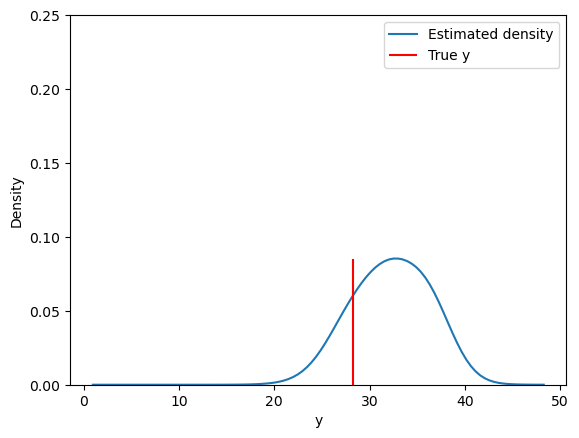

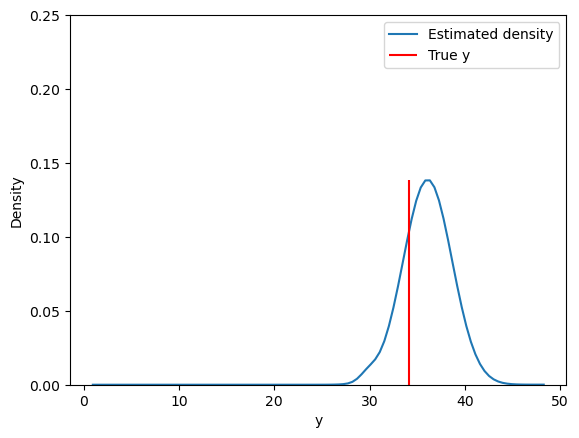

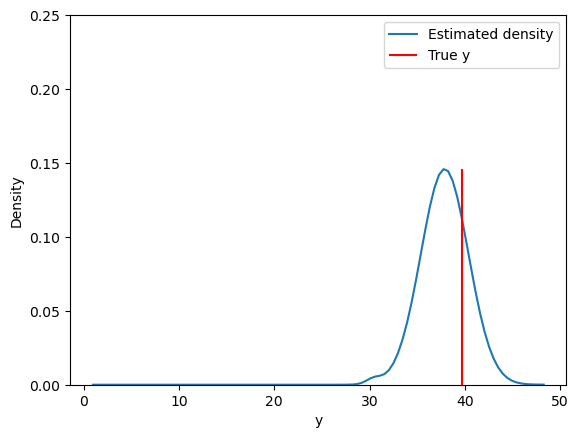

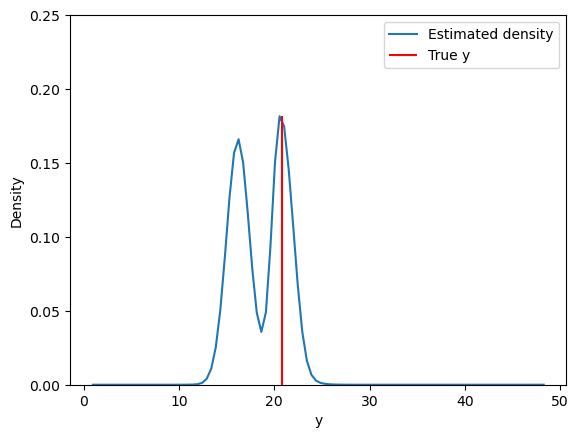

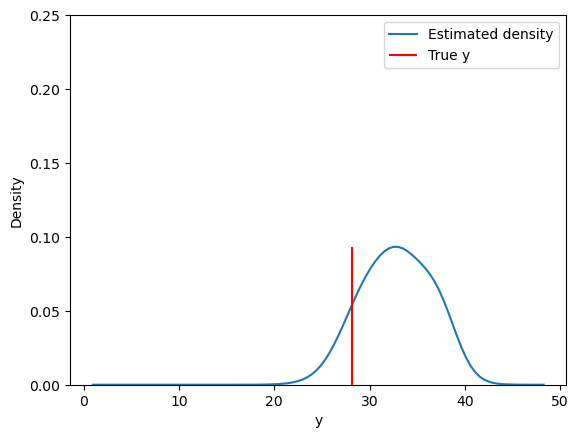

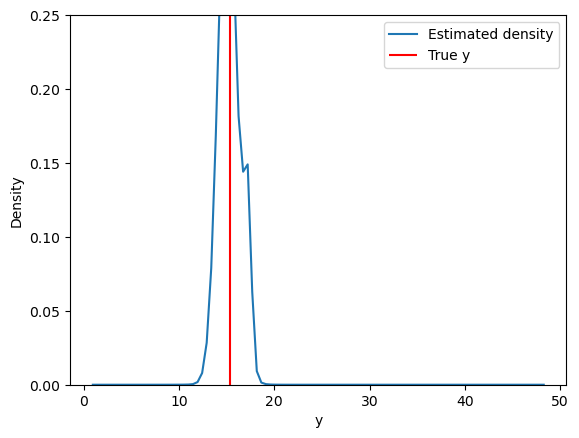

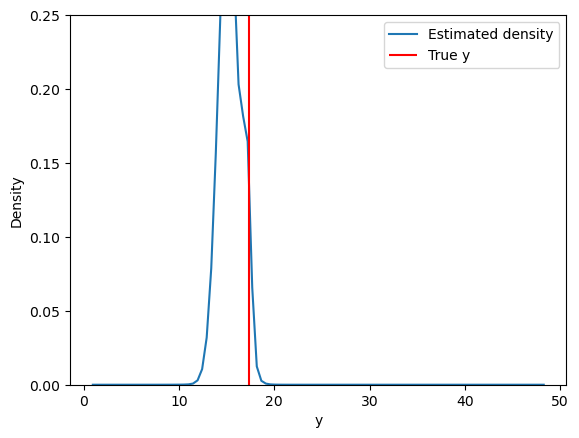

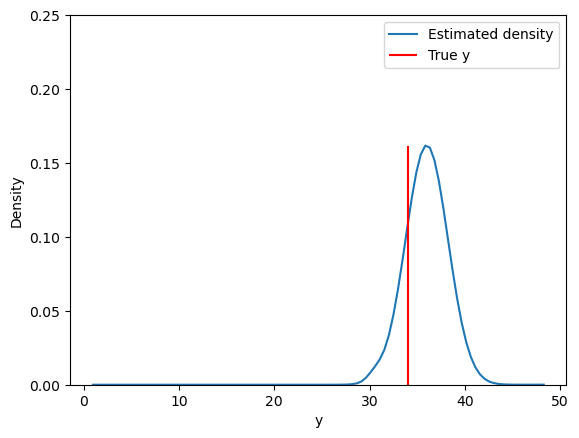

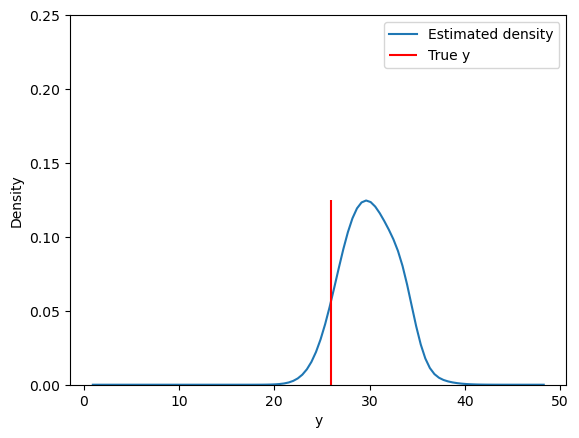

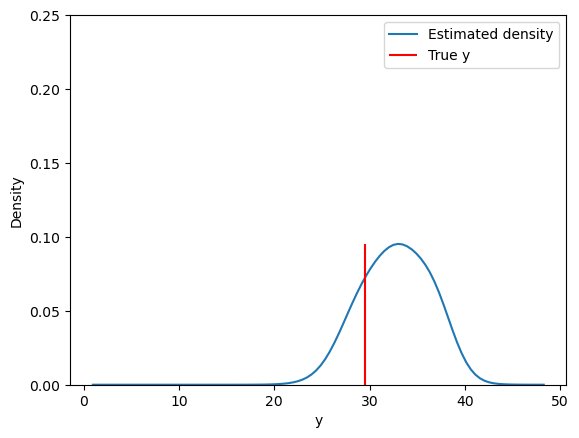

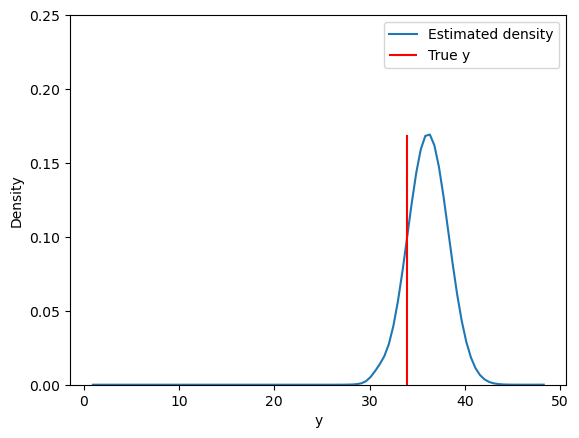

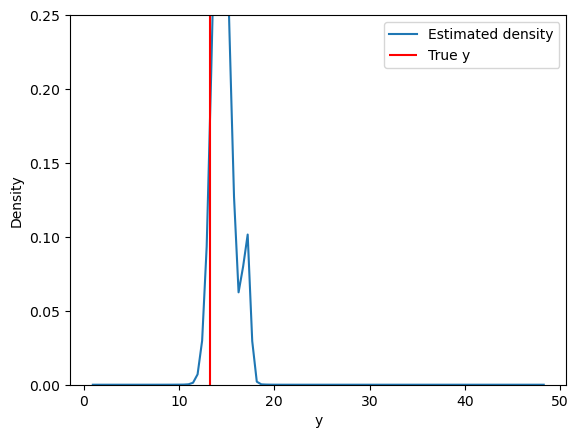

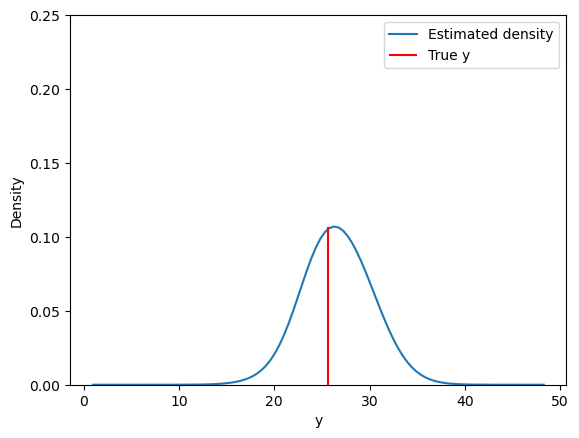

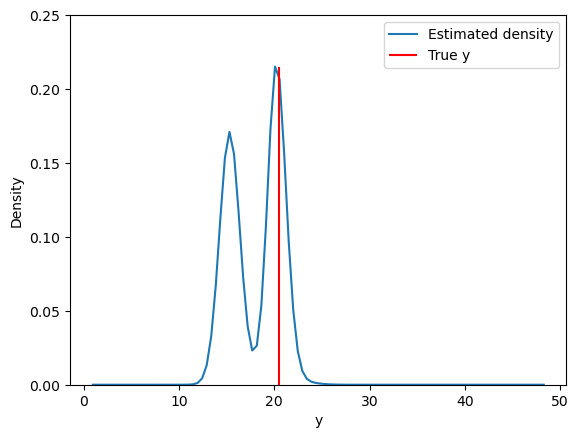

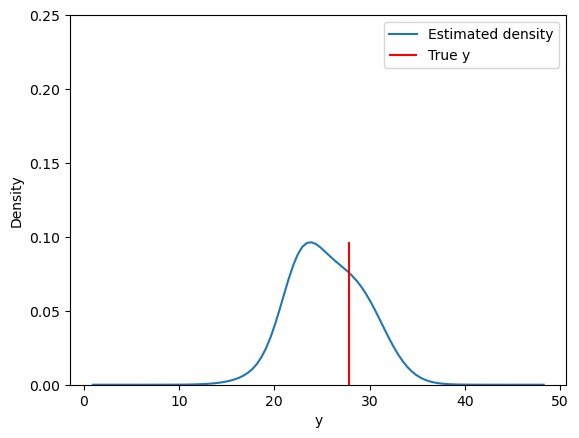

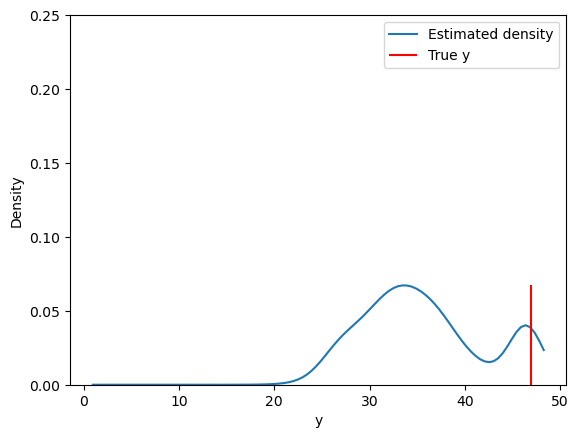

In [17]:
num_steps = 100
num_std = 2.5
max_density_for_plt = 0.25
num_samples = 150
x, y = next(iter(data_module.get_train_dataloader(num_samples, shuffle=False)))
mean_y, std_y = data_module.train_dataset.scaler_y
y_space = torch.linspace(mean_y.item()-num_std*std_y.item(), mean_y.item()+num_std*std_y.item(), num_steps, device=x.device).view(-1, 1)
precomputed_variables = model.forward(x, y)
numeric_stability = 1e-6

for idx in range(x.shape[0]):
    x_space = x[idx].unsqueeze(0).expand(num_steps, -1)
    # Calculate estimated density
    if precomputed_variables:
        to_pass_precomputed_variables = {
            key: value[idx].unsqueeze(0).expand(num_steps, -1)
            for key, value in precomputed_variables.items()
        }
        estimated_densities = model.get_density(
            x_space, y_space, numeric_stability, **to_pass_precomputed_variables
        )
    else:
        estimated_densities = model.get_density(x_space, y_space, numeric_stability)
    

    plt.plot(y_space.detach().cpu().numpy(), estimated_densities.detach().cpu().numpy(), label="Estimated density")
    plt.ylabel("Density")
    plt.xlabel("y")
    plt.vlines(y[idx].item(), 0, estimated_densities.max().item(), colors="r", label="True y")
    plt.ylim(0, max_density_for_plt)
    plt.legend()
    plt.show()

In [14]:
model.mlp.hidden_layers[2]

Linear(in_features=64, out_features=32, bias=True)

In [18]:
print(model.mlp.output_layer.weight.data.abs().max())
print(model.mlp.output_layer.bias.data.abs().max())

tensor(0.4709)
tensor(0.2532)
